# 다이소 화장품 EDA v2 - 심화 분석

## 0. 데이터 전처리 및 품질 정제

### 0.0. 라이브러리 및 데이터 로딩

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import sys
import os
warnings.filterwarnings('ignore')

# RQ 유틸리티 import
sys.path.append('/Users/yu_seok/Documents/workspace/nbCamp/Project/Why-pi/RQ')
from utils.keyword_analysis import (
    KEYWORD_CATEGORIES,
    calculate_category_frequency_regex,
    match_category_patterns_in_text,
    extract_reviews_with_keywords
)
from utils.text_preprocessing import preprocess_text, tokenize_reviews
from utils.visualization import (
    create_wordcloud,
    plot_keyword_frequency,
    plot_category_comparison
)

# 시각화 스타일
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6) 

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Noto Sans KR'
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 로딩 완료")

라이브러리 로딩 완료


In [18]:
# 데이터 로딩
data_dir = '/Users/yu_seok/Documents/workspace/nbCamp/Project/Why-pi/data'

products_df = pd.read_parquet(f'{data_dir}/products.parquet')
reviews_df = pd.read_parquet(f'{data_dir}/reviews.parquet')

print(f"제품 데이터: {len(products_df):,}개")
print(f"리뷰 데이터: {len(reviews_df):,}개")
print(f"\n제품 컬럼: {products_df.columns.tolist()}")
print(f"리뷰 컬럼: {reviews_df.columns.tolist()}")

제품 데이터: 868개
리뷰 데이터: 312,139개

제품 컬럼: ['product_code', 'category_home', 'category_1', 'category_2', 'brand', 'name', 'price', 'country', 'likes', 'shares', 'group']
리뷰 컬럼: ['product_code', 'date', 'user_masked', 'user', 'rating', 'text', 'image_count', 'user_id', 'order_id']


In [19]:
# 파생변수가 포함된 데이터 로딩
data_dir = '/Users/yu_seok/Documents/workspace/nbCamp/Project/Why-pi/data'

products_df = pd.read_parquet(f'{data_dir}/products_with_features.parquet')
reviews_df = pd.read_parquet(f'{data_dir}/reviews_with_features.parquet')

print(f"제품 데이터: {len(products_df):,}개")
print(f"리뷰 데이터: {len(reviews_df):,}개")
print(f"\n제품 컬럼 ({len(products_df.columns)}개): {products_df.columns.tolist()}")
print(f"\n리뷰 컬럼 ({len(reviews_df.columns)}개): {reviews_df.columns.tolist()}")

# 파생변수 확인
print(f"\n=== 제품 파생변수 ===")
print(f"engagement_score: {products_df['engagement_score'].describe()}")
print(f"\ncp_index: {products_df['cp_index'].describe()}")
print(f"\nprice_tier 분포:\n{products_df['price_tier'].value_counts()}")

print(f"\n=== 리뷰 파생변수 ===")
print(f"재구매 리뷰: {reviews_df['is_reorder'].sum():,}개 ({reviews_df['is_reorder'].mean()*100:.1f}%)")
print(f"\nuser_activity_level 분포:\n{reviews_df['user_activity_level'].value_counts()}")
print(f"\nreview_length_category 분포:\n{reviews_df['review_length_category'].value_counts()}")

제품 데이터: 868개
리뷰 데이터: 312,139개

제품 컬럼 (19개): ['product_code', 'category_home', 'category_1', 'category_2', 'brand', 'name', 'price', 'country', 'likes', 'shares', 'group', 'review_count', 'engagement_score', 'price_tier', 'relative_price_ratio', 'price_position', 'cp_index', 'is_god_sung_bi', 'review_density']

리뷰 컬럼 (28개): ['product_code', 'date', 'user_masked', 'user', 'rating', 'text', 'image_count', 'user_id', 'order_id', 'review_length', 'review_length_category', 'is_reorder', 'user_total_reviews', 'user_activity_level', 'user_avg_rating_reorder', 'user_rating_tendency', 'is_brand_repurchase', 'is_category_repurchase', 'year', 'month', 'day_of_week', 'day_name', 'season', 'first_review_date', 'days_since_first_review', 'is_new_product', 'is_during_promo', 'promo_type_category']

=== 제품 파생변수 ===
engagement_score: count     868.000000
mean      597.548157
std       758.877897
min         0.000000
25%       158.450000
50%       312.300000
75%       756.375000
max      6998.300000
Name

In [20]:
# # 맨케어 제품 제거

# print("=== 맨케어 제품 필터링 전 ===" )
# print(f"제품 수: {len(products_df):,}개")
# print(f"리뷰 수: {len(reviews_df):,}개")

# # 카테고리 확인
# print("\n카테고리 분포:")
# print(products_df['category_1'].value_counts())

# # 맨케어 제품 찾기
# men_care_keywords = ['맨케어', '남성', '면도', 'MEN', 'men', 'Man', 'man']

# # category_1, category_2, name에서 맨케어 키워드 검색
# men_care_mask = (
#     products_df['category_1'].str.contains('|'.join(men_care_keywords), case=False, na=False) |
#     products_df['category_2'].fillna('').str.contains('|'.join(men_care_keywords), case=False, na=False) |
#     products_df['name'].str.contains('|'.join(men_care_keywords), case=False, na=False)
# )

# men_care_products = products_df[men_care_mask].copy()

# print(f"\n=== 발견된 맨케어 제품 ===" )
# print(f"맨케어 제품 수: {len(men_care_products)}개")
# if len(men_care_products) > 0:
#     print("\n맨케어 제품 목록:")
#     print(men_care_products[['product_code', 'category_1', 'category_2', 'name', 'brand']].to_string())

# # 맨케어 제품 코드 추출
# men_care_codes = men_care_products['product_code'].tolist()

# # 맨케어 제품 및 해당 리뷰 제거
# products_df = products_df[~men_care_mask].copy()
# reviews_df = reviews_df[~reviews_df['product_code'].isin(men_care_codes)].copy()

# # 인덱스 리셋
# products_df.reset_index(drop=True, inplace=True)
# reviews_df.reset_index(drop=True, inplace=True)

# print(f"\n=== 맨케어 제품 필터링 후 ===" )
# print(f"제품 수: {len(products_df):,}개 (제거: {len(men_care_products)}개)")
# print(f"리뷰 수: {len(reviews_df):,}개")
# print("\n✓ 맨케어 제품 제거 완료")

In [21]:
# # 중복 리뷰 분석
# print("=== 중복 리뷰 분석 ===")
# print(f"원본 리뷰 수: {len(reviews_df):,}개\n")

# # 1. 동일 텍스트 그룹 찾기 (상품이 다른 경우)
# duplicate_analysis = reviews_df.groupby('text').agg({
#     'product_code': 'nunique',  # 몇 개의 다른 상품에 달렸는지
#     'user': 'nunique',           # 몇 명의 다른 유저가 작성했는지
#     'rating': lambda x: list(x.unique()),
#     'date': 'count'              # 동일 텍스트가 몇 번 나타났는지
# }).rename(columns={'date': 'count'})

# # 2개 이상의 상품에 동일 리뷰가 달린 케이스
# suspicious_duplicates = duplicate_analysis[
#     (duplicate_analysis['product_code'] > 1) &
#     (duplicate_analysis['count'] > 1)
# ].sort_values('count', ascending=False)

# print(f"동일 텍스트가 여러 상품에 등장하는 케이스: {len(suspicious_duplicates):,}개")
# print(f"\n상위 10개 중복 케이스:")
# print(suspicious_duplicates.head(10))

# # 중복 리뷰 샘플 확인
# if len(suspicious_duplicates) > 0:
#     print("\n=== 중복 리뷰 샘플 ===")
#     for idx, (text, row) in enumerate(suspicious_duplicates.head(3).iterrows(), 1):
#         print(f"\n[{idx}] 텍스트: {text[:50]}...")
#         print(f"    등장 횟수: {row['count']}번")
#         print(f"    다른 상품 수: {row['product_code']}개")
#         print(f"    다른 유저 수: {row['user']}명")
#         print(f"    평점: {row['rating']}")

**목적**:
- 동일한 리뷰 텍스트가 여러 제품에 반복적으로 등장하는 경우를 탐지하고 제거
- 스팸성 리뷰나 복사-붙여넣기 리뷰로 인한 데이터 왜곡 방지

**방법**:
1. 동일 텍스트가 3개 이상의 다른 제품에 등장하는 케이스 식별
2. 해당 리뷰들을 모두 제거 (명백한 스팸으로 간주)

In [22]:
# # 중복 리뷰 제거 전략
# # 전략 1: 동일 텍스트가 3개 이상 상품에 등장하면 모두 제거 (명백한 스팸)
# # 전략 2: 동일 유저가 동일 텍스트를 여러 상품에 작성한 경우 최신것만 유지

# # 제거할 리뷰 식별
# texts_to_remove = suspicious_duplicates[suspicious_duplicates['product_code'] >= 3].index.tolist()

# print(f"\n제거할 중복 텍스트 수: {len(texts_to_remove)}개")

# # 중복 제거
# reviews_cleaned = reviews_df[~reviews_df['text'].isin(texts_to_remove)].copy()

# print(f"\n원본 리뷰: {len(reviews_df):,}개")
# print(f"제거된 리뷰: {len(reviews_df) - len(reviews_cleaned):,}개")
# print(f"정제된 리뷰: {len(reviews_cleaned):,}개")

# # 정제된 데이터로 교체
# reviews_df = reviews_cleaned.copy()

# 제품 파생변수 설명

이미 생성된 파생변수들:
- **engagement_score**: 제품의 종합 참여도 (0.15*likes + 0.30*shares + 0.55*review_count)
- **price_tier**: 카테고리 내 가격대 (Low/Mid/High)
- **price_position**: 카테고리 내 가격 백분위 위치 (0.0~1.0)
- **relative_price_ratio**: 카테고리 평균 대비 가격 비율
- **cp_index**: 가성비 지표 (engagement_score / (price + 1))
- **is_god_sung_bi**: 갓성비 아이템 여부 (카테고리 내 cp_index 상위 20%)
- **review_density**: 리뷰 밀도 (review_count / days_since_first_review)

상세 설명: `/Users/yu_seok/Documents/workspace/nbCamp/Project/Why-pi/docs/DERIVED_FEATURES.md` 참조

# 리뷰 파생변수 설명

이미 생성된 파생변수들:

**기본 변수**
- **review_length**: 리뷰 텍스트 길이
- **review_length_category**: 리뷰 길이 카테고리 (Very Short/Short/Medium/Long/Very Long)
- **is_reorder**: 재구매 리뷰 여부 (텍스트가 '재구매'로 시작)

**사용자 관련 변수**
- **user_total_reviews**: 사용자가 작성한 총 리뷰 수
- **user_activity_level**: 사용자 활동 수준 (Light/Medium/Active/Heavy)
- **user_avg_rating_reorder**: 재구매 리뷰 평균 평점
- **user_rating_tendency**: 평점 부여 성향 (No Reorder/Always Positive/Mostly Positive/Neutral/Critical)
- **is_brand_repurchase**: 브랜드 재구매 여부
- **is_category_repurchase**: 카테고리 재구매 여부

**시간 관련 변수**
- **year, month, day_of_week, day_name**: 리뷰 작성 시간 정보
- **season**: 계절 (봄/여름/가을/겨울)
- **first_review_date**: 제품의 첫 리뷰 날짜
- **days_since_first_review**: 첫 리뷰 이후 경과 일수
- **is_new_product**: 신제품 여부 (첫 리뷰 이후 30일 이내)

**프로모션 관련 변수**
- **is_during_promo**: 프로모션 기간 내 작성 여부
- **promo_type_category**: 프로모션 유형 (신상품/할인/구매이벤트/리뷰이벤트/기타)



In [23]:
# 리뷰 파생변수 생성
# 날짜 변수
reviews_df['date'] = pd.to_datetime(reviews_df['date'])
reviews_df['year'] = reviews_df['date'].dt.year
reviews_df['month'] = reviews_df['date'].dt.month

# 재구매 플래그
reviews_df['is_reorder'] = reviews_df['text'].fillna('').str.strip().str.startswith('재구매')

# 리뷰 길이
reviews_df['review_length'] = reviews_df['text'].fillna('').str.len()

print(f"재구매 리뷰: {reviews_df['is_reorder'].sum():,}개 ({reviews_df['is_reorder'].mean()*100:.1f}%)")
print(f"평균 리뷰 길이: {reviews_df['review_length'].mean():.1f}자")

재구매 리뷰: 94,439개 (30.3%)
평균 리뷰 길이: 35.9자


In [25]:
# User Activity Level 생성 (유저별 리뷰 작성 횟수 기반)
user_activity = reviews_df.groupby('user').size().reset_index(name='user_review_count')

# 활동 등급 분류
def classify_user_activity(count):
    if count >= 20:
        return 'Very Active'
    elif count >= 10:
        return 'Active'
    elif count >= 5:
        return 'Moderate'
    else:
        return 'Casual'

user_activity['user_activity_level'] = user_activity['user_review_count'].apply(classify_user_activity)

# 리뷰에 병합
reviews_df = reviews_df.merge(user_activity[['user', 'user_activity_level']], on='user', how='left')

print("User Activity Level 분포:")
print(reviews_df['user_activity_level'].value_counts())
print(f"\n활동 등급별 비율:")
print(reviews_df['user_activity_level'].value_counts(normalize=True) * 100)

User Activity Level 분포:
user_activity_level
Very Active    228143
Active          44974
Moderate        22672
Casual          16350
Name: count, dtype: int64

활동 등급별 비율:
user_activity_level
Very Active    73.090194
Active         14.408324
Moderate        7.263431
Casual          5.238051
Name: proportion, dtype: float64


### 3-1. User Activity Level별 낮은 별점(1-3점) 비율

**분석 목적**:
- 활동 등급별로 낮은 별점(1-3점)을 주는 비율이 다른지 분석
- 활발한 사용자일수록 더 비판적인지 확인

**기대 결과**:
- 활동 등급별 낮은 별점 비율 정량화
- 파워 유저의 평가 경향성 파악

In [26]:
# User Activity Level별 낮은 별점(1-3점) 비율 분석
# 낮은 별점(1-3점) 정의
reviews_df['is_low_rating'] = (reviews_df['rating'] <= 3).astype(int)

# Activity Level별 낮은 별점 비율 계산
low_rating_stats = reviews_df.groupby('user_activity_level').agg({
    'is_low_rating': ['sum', 'mean', 'count']
}).round(3)

low_rating_stats.columns = ['낮은별점_수', '낮은별점_비율', '전체_리뷰수']
low_rating_stats['낮은별점_비율_퍼센트'] = (low_rating_stats['낮은별점_비율'] * 100).round(2)
low_rating_stats = low_rating_stats.sort_values('전체_리뷰수', ascending=False)

print("\n=== User Activity Level별 낮은 별점(1-3점) 비율 ===")
print(low_rating_stats)


=== User Activity Level별 낮은 별점(1-3점) 비율 ===
                     낮은별점_수  낮은별점_비율  전체_리뷰수  낮은별점_비율_퍼센트
user_activity_level                                      
Very Active           12016    0.053  228143          5.3
Active                 2576    0.057   44974          5.7
Moderate               1281    0.057   22672          5.7
Casual                  855    0.052   16350          5.2


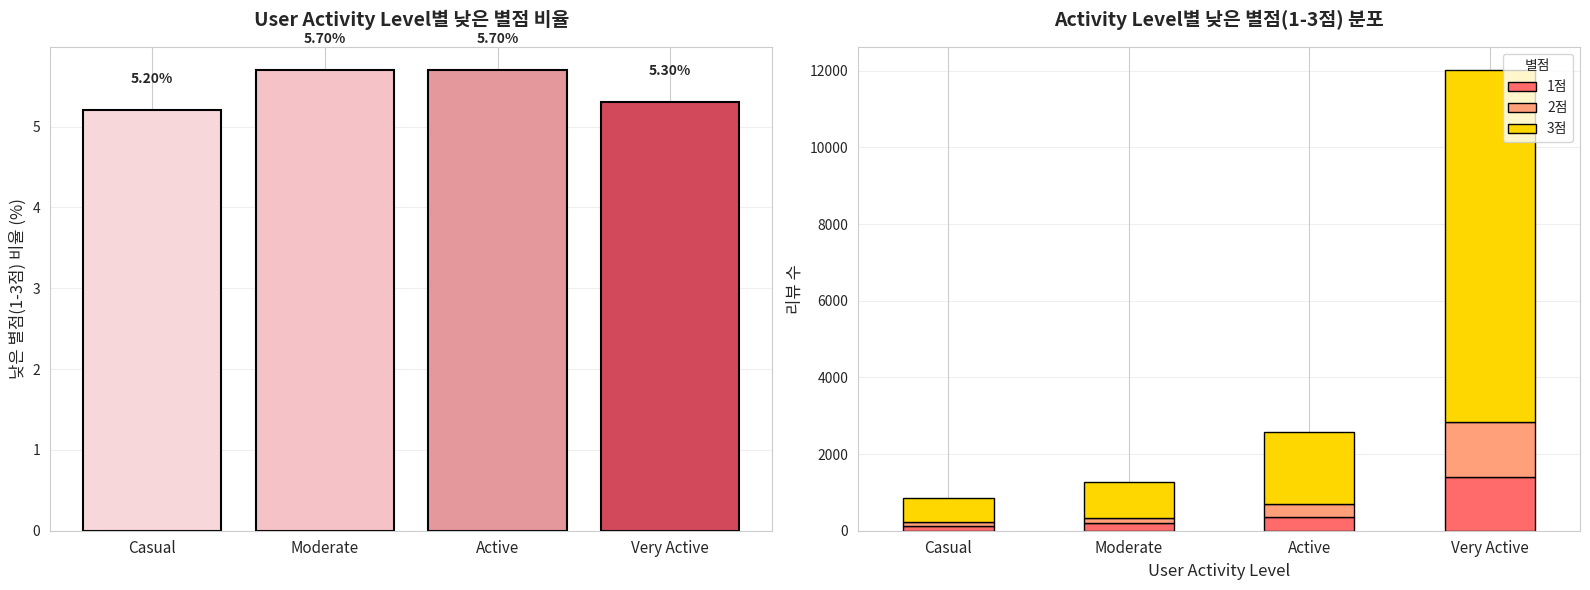

In [27]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Activity Level별 낮은 별점 비율
activity_order = ['Casual', 'Moderate', 'Active', 'Very Active']
low_rating_stats_sorted = low_rating_stats.loc[activity_order]

axes[0].bar(range(len(low_rating_stats_sorted)),
            low_rating_stats_sorted['낮은별점_비율_퍼센트'],
            color=['#F8D7DA', '#F5C2C7', '#E5989B', '#D1495B'],
            edgecolor='black', linewidth=1.5)
axes[0].set_xticks(range(len(low_rating_stats_sorted)))
axes[0].set_xticklabels(activity_order, fontsize=11)
axes[0].set_ylabel('낮은 별점(1-3점) 비율 (%)', fontsize=12)
axes[0].set_title('User Activity Level별 낮은 별점 비율', fontsize=14, fontweight='bold', pad=15)
axes[0].grid(axis='y', alpha=0.3)

# 막대에 값 표시
for i, (idx, row) in enumerate(low_rating_stats_sorted.iterrows()):
    axes[0].text(i, row['낮은별점_비율_퍼센트'] + 0.3, 
                f"{row['낮은별점_비율_퍼센트']:.2f}%",
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# 별점별 분포 (1, 2, 3점)
rating_dist = reviews_df[reviews_df['rating'] <= 3].groupby(['user_activity_level', 'rating']).size().unstack(fill_value=0)
rating_dist = rating_dist.loc[activity_order]

rating_dist.plot(kind='bar', stacked=True, ax=axes[1],
                 color=['#FF6B6B', '#FFA07A', '#FFD700'],
                 edgecolor='black', linewidth=1)
axes[1].set_xlabel('User Activity Level', fontsize=12)
axes[1].set_ylabel('리뷰 수', fontsize=12)
axes[1].set_title('Activity Level별 낮은 별점(1-3점) 분포', fontsize=14, fontweight='bold', pad=15)
axes[1].legend(title='별점', labels=['1점', '2점', '3점'], loc='upper right')
axes[1].set_xticklabels(activity_order, rotation=0, fontsize=11)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [28]:
# 추가 인사이트: 높은 별점(5점)과 낮은 별점(1-3점) 비율 비교
print("\n=== 활동 등급별 별점 분포 요약 ===")
rating_summary = reviews_df.groupby('user_activity_level')['rating'].apply(
    lambda x: pd.Series({
        '5점_비율(%)': (x == 5).sum() / len(x) * 100,
        '낮은별점_비율(%)': (x <= 3).sum() / len(x) * 100,
        '평균_평점': x.mean()
    })
).round(2)
rating_summary = rating_summary.loc[activity_order]
print(rating_summary)


=== 활동 등급별 별점 분포 요약 ===
user_activity_level            
Casual               5점_비율(%)      81.53
                     낮은별점_비율(%)     5.23
                     평균_평점          4.74
Moderate             5점_비율(%)      81.32
                     낮은별점_비율(%)     5.65
                     평균_평점          4.73
Active               5점_비율(%)      80.96
                     낮은별점_비율(%)     5.73
                     평균_평점          4.73
Very Active          5점_비율(%)      81.86
                     낮은별점_비율(%)     5.27
                     평균_평점          4.75
Name: rating, dtype: float64


## 1. 리뷰 밀도와 Engagement Score 상관관계

**분석 목적**:
- 리뷰 밀도(Review Density)와 참여도(Engagement Score)가 어떤 관계인지 파악
- 높은 engagement에도 리뷰가 적은 제품 vs 리뷰는 많지만 engagement가 낮은 제품 비교

In [29]:
# 리뷰 밀도와 Engagement Score 상관관계 분석
# 상관계수 계산
correlation = products_df['review_density'].corr(products_df['engagement_score'])
print(f"리뷰 밀도 vs Engagement Score 상관계수: {correlation:.4f}")

리뷰 밀도 vs Engagement Score 상관계수: 0.2599


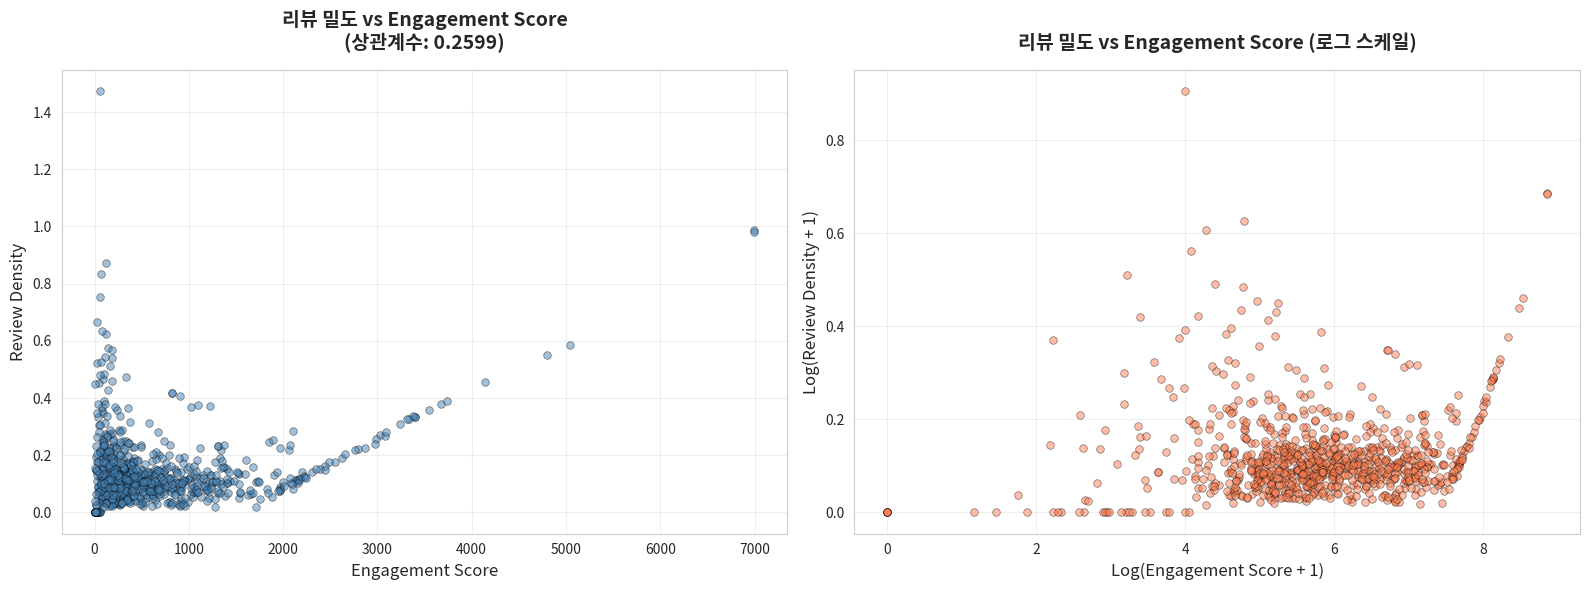

In [30]:
# 산점도
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 전체 산점도
axes[0].scatter(products_df['engagement_score'],
                products_df['review_density'],
                alpha=0.5, s=30, c='steelblue', edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('Engagement Score', fontsize=12)
axes[0].set_ylabel('Review Density', fontsize=12)
axes[0].set_title(f'리뷰 밀도 vs Engagement Score\n(상관계수: {correlation:.4f})',
                  fontsize=14, fontweight='bold', pad=15)
axes[0].grid(True, alpha=0.3)

# 로그 스케일 산점도 (분포 확인)
axes[1].scatter(np.log1p(products_df['engagement_score']),
                np.log1p(products_df['review_density']),
                alpha=0.5, s=30, c='coral', edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Log(Engagement Score + 1)', fontsize=12)
axes[1].set_ylabel('Log(Review Density + 1)', fontsize=12)
axes[1].set_title('리뷰 밀도 vs Engagement Score (로그 스케일)',
                  fontsize=14, fontweight='bold', pad=15)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [31]:
# 이상치 제품 탐지
# 높은 engagement, 낮은 review density (좋아요/공유는 많지만 리뷰가 적음)
high_eng_low_density = products_df[
    (products_df['engagement_score'] > products_df['engagement_score'].quantile(0.75)) &
    (products_df['review_density'] < products_df['review_density'].quantile(0.25))
].sort_values('engagement_score', ascending=False)

print(f"높은 Engagement, 낮은 Review Density 제품: {len(high_eng_low_density)}개")
print("\n상위 10개 제품:")
print(high_eng_low_density[['name', 'engagement_score', 'review_density', 'likes', 'shares', 'review_count']].head(10))

# 낮은 engagement, 높은 review density (리뷰는 많지만 좋아요/공유가 적음)
low_eng_high_density = products_df[
    (products_df['engagement_score'] < products_df['engagement_score'].quantile(0.25)) &
    (products_df['review_density'] > products_df['review_density'].quantile(0.75))
].sort_values('review_density', ascending=False)

print(f"\n낮은 Engagement, 높은 Review Density 제품: {len(low_eng_high_density)}개")
print("\n상위 10개 제품:")
print(low_eng_high_density[['name', 'engagement_score', 'review_density', 'likes', 'shares', 'review_count']].head(10))

높은 Engagement, 낮은 Review Density 제품: 42개

상위 10개 제품:
                                     name  engagement_score  review_density  \
811                   VT PDRN 광채토너 200 ml           1876.40        0.052705   
797         그로우어스 롱래스팅 클리어 앤 틴팅 2IN1 래쉬세럼           1837.10        0.066887   
35        [72 리틀 오스틴]프릴루드 딘토 노스탈지아 아이 팔레트           1753.85        0.046400   
674           더랩바이블랑두 클리어히알결광 스킨핏프렙 40 ml           1710.55        0.019602   
689            닥터오라클 큐어소나 쿨링코드 수딩젤크림 50ml           1678.55        0.067633   
247  비프루브 마린 캡슐 선세럼 35 ml (SPF50+,PA++++)           1659.10        0.063388   
373             어퓨 더퓨어 후시디움 레드 스팟 세럼 8 ml           1628.10        0.060845   
690         닥터오라클 큐어소나 오투 카밍 리페어 앰플 40 ml           1546.80        0.069236   
705              닥터씨피유 딥클린 효소 파우더 워시 60 g           1541.90        0.070662   
346        밀크터치 디어씽 블러리 이펙트 스무드 터치팟 뮤트메모리           1532.55        0.049645   

     likes  shares  review_count  
811   9999     289           527  
797   9

## 3. User Activity Level별 평균 별점

**분석 목적**:
- 유저의 활동 등급(Casual, Moderate, Active, Very Active)에 따라 평점 패턴이 다른지 분석
- 활동이 많은 유저일수록 평점이 더 엄격한지 또는 관대한지 파악

In [32]:
# User Activity Level별 평균 별점 분석
activity_rating_stats = reviews_df.groupby('user_activity_level').agg({
    'rating': ['mean', 'std', 'count', 'median']
}).round(3)

activity_rating_stats.columns = ['평균_평점', '표준편차', '리뷰_수', '중앙값']
activity_rating_stats = activity_rating_stats.sort_values('리뷰_수', ascending=False)

print("=== User Activity Level별 평점 통계 ===")
print(activity_rating_stats)

=== User Activity Level별 평점 통계 ===
                     평균_평점   표준편차    리뷰_수  중앙값
user_activity_level                           
Very Active          4.747  0.617  228143  5.0
Active               4.729  0.649   44974  5.0
Moderate             4.733  0.648   22672  5.0
Casual               4.741  0.632   16350  5.0


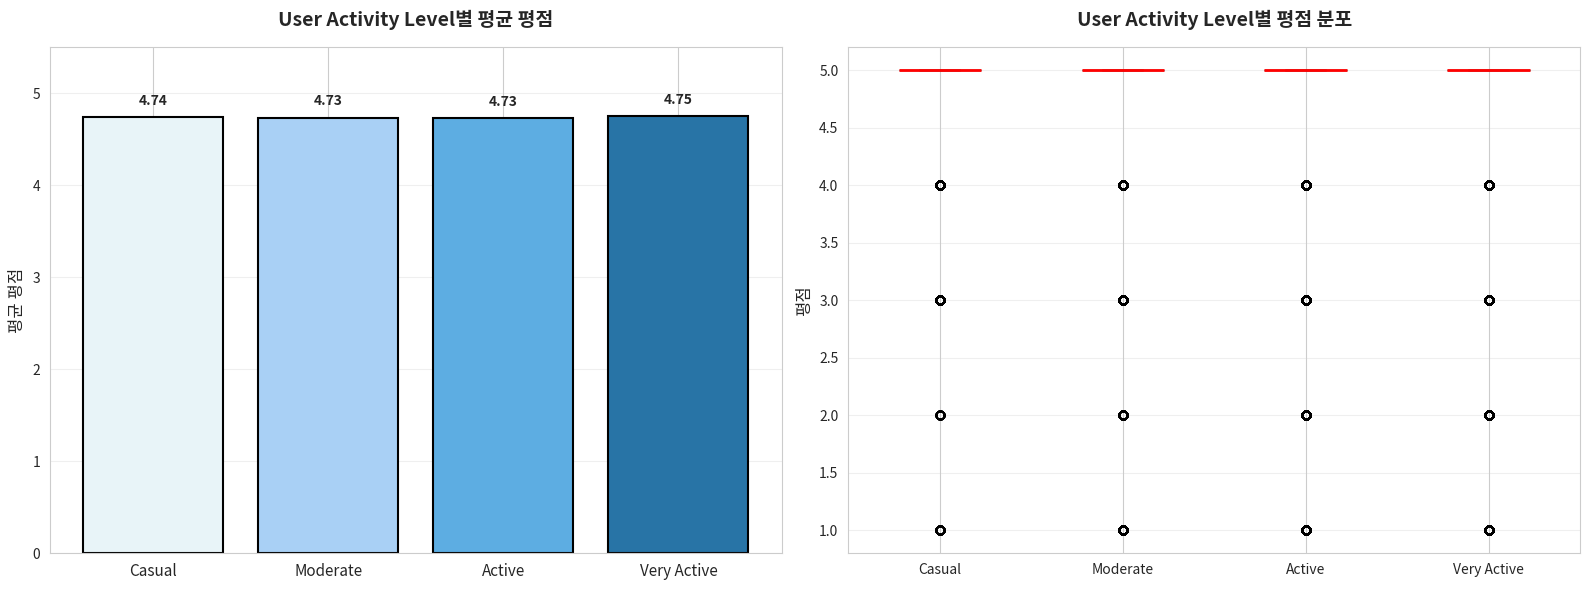

In [33]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 평균 평점 막대 그래프
activity_order = ['Casual', 'Moderate', 'Active', 'Very Active']
activity_rating_stats_sorted = activity_rating_stats.loc[activity_order]

axes[0].bar(range(len(activity_rating_stats_sorted)),
            activity_rating_stats_sorted['평균_평점'],
            color=['#E8F4F8', '#A9D0F5', '#5DADE2', '#2874A6'],
            edgecolor='black', linewidth=1.5)
axes[0].set_xticks(range(len(activity_rating_stats_sorted)))
axes[0].set_xticklabels(activity_order, fontsize=11)
axes[0].set_ylabel('평균 평점', fontsize=12)
axes[0].set_ylim(0, 5.5)
axes[0].set_title('User Activity Level별 평균 평점', fontsize=14, fontweight='bold', pad=15)
axes[0].grid(axis='y', alpha=0.3)

# 평점에 값 표시
for i, (idx, row) in enumerate(activity_rating_stats_sorted.iterrows()):
    axes[0].text(i, row['평균_평점'] + 0.1, f"{row['평균_평점']:.2f}",
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# 박스플롯
activity_data = [reviews_df[reviews_df['user_activity_level'] == level]['rating'].values
                 for level in activity_order]
bp = axes[1].boxplot(activity_data, labels=activity_order, patch_artist=True,
                      boxprops=dict(facecolor='lightblue', alpha=0.7),
                      medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('평점', fontsize=12)
axes[1].set_title('User Activity Level별 평점 분포', fontsize=14, fontweight='bold', pad=15)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [34]:
# 통계적 유의성 검정 (ANOVA)
from scipy.stats import f_oneway

# 각 그룹의 평점 데이터
casual_ratings = reviews_df[reviews_df['user_activity_level'] == 'Casual']['rating']
moderate_ratings = reviews_df[reviews_df['user_activity_level'] == 'Moderate']['rating']
active_ratings = reviews_df[reviews_df['user_activity_level'] == 'Active']['rating']
very_active_ratings = reviews_df[reviews_df['user_activity_level'] == 'Very Active']['rating']

# ANOVA 검정
f_stat, p_value = f_oneway(casual_ratings, moderate_ratings, active_ratings, very_active_ratings)

print(f"\n=== ANOVA 검정 결과 ===")
print(f"F-통계량: {f_stat:.4f}")
print(f"p-value: {p_value:.6f}")

if p_value < 0.05:
    print("\n결론: 활동 등급 간 평균 평점 차이가 통계적으로 유의합니다 (p < 0.05)")
else:
    print("\n결론: 활동 등급 간 평균 평점 차이가 통계적으로 유의하지 않습니다 (p >= 0.05)")


=== ANOVA 검정 결과 ===
F-통계량: 13.2185
p-value: 0.000000

결론: 활동 등급 간 평균 평점 차이가 통계적으로 유의합니다 (p < 0.05)


## 8. 좋아요/공유 수와 브랜드 상관관계

**분석 목적**:
- 브랜드별로 좋아요/공유 수가 다른지 분석
- 특정 브랜드가 소셜 engagement에서 유리한지 파악

In [35]:
# 브랜드별 좋아요/공유 통계
brand_engagement = products_df.groupby('brand').agg({
    'likes': ['mean', 'sum', 'count'],
    'shares': ['mean', 'sum'],
    'review_count': 'mean'
}).round(2)

brand_engagement.columns = ['평균_좋아요', '총_좋아요', '제품_수', '평균_공유', '총_공유', '평균_리뷰수']

# 제품 수가 5개 이상인 브랜드만 분석 (신뢰도 확보)
brand_engagement_filtered = brand_engagement[brand_engagement['제품_수'] >= 5].copy()

print(f"분석 대상 브랜드 수: {len(brand_engagement_filtered)}개 (제품 5개 이상)")
print(f"\n평균 좋아요 상위 10개 브랜드:")
print(brand_engagement_filtered.nlargest(10, '평균_좋아요')[['평균_좋아요', '평균_공유', '평균_리뷰수', '제품_수']])

print(f"\n평균 공유 상위 10개 브랜드:")
print(brand_engagement_filtered.nlargest(10, '평균_공유')[['평균_좋아요', '평균_공유', '평균_리뷰수', '제품_수']])

분석 대상 브랜드 수: 59개 (제품 5개 이상)

평균 좋아요 상위 10개 브랜드:
            평균_좋아요   평균_공유   평균_리뷰수  제품_수
brand                                    
닥터오라클      7356.20   82.30   601.60    10
마데카21      7078.33  199.33  2072.78     9
VT         6602.73  130.05  2071.32    22
김정문알로에     6432.40   74.40   648.80     5
미모 바이 마몽드  6138.38   85.75   719.00     8
바이 리얼베리어   5669.60  105.20   502.80     5
셀더마데일리     5071.60  112.80   944.40     5
메디필        5031.56   72.56   673.06    18
클리덤        4616.12   85.12   504.69    16
파티온        4304.83  138.33   339.33     6

평균 공유 상위 10개 브랜드:
            평균_좋아요   평균_공유   평균_리뷰수  제품_수
brand                                    
마데카21      7078.33  199.33  2072.78     9
파티온        4304.83  138.33   339.33     6
VT         6602.73  130.05  2071.32    22
더랩 바이 블랑두  4055.13  123.53   435.13    15
셀더마데일리     5071.60  112.80   944.40     5
바이 리얼베리어   5669.60  105.20   502.80     5
줌 바이 정샘물   3917.08   89.17   105.42    12
미모 바이 마몽드  6138.38   85.75   719.00     8
클리덤      

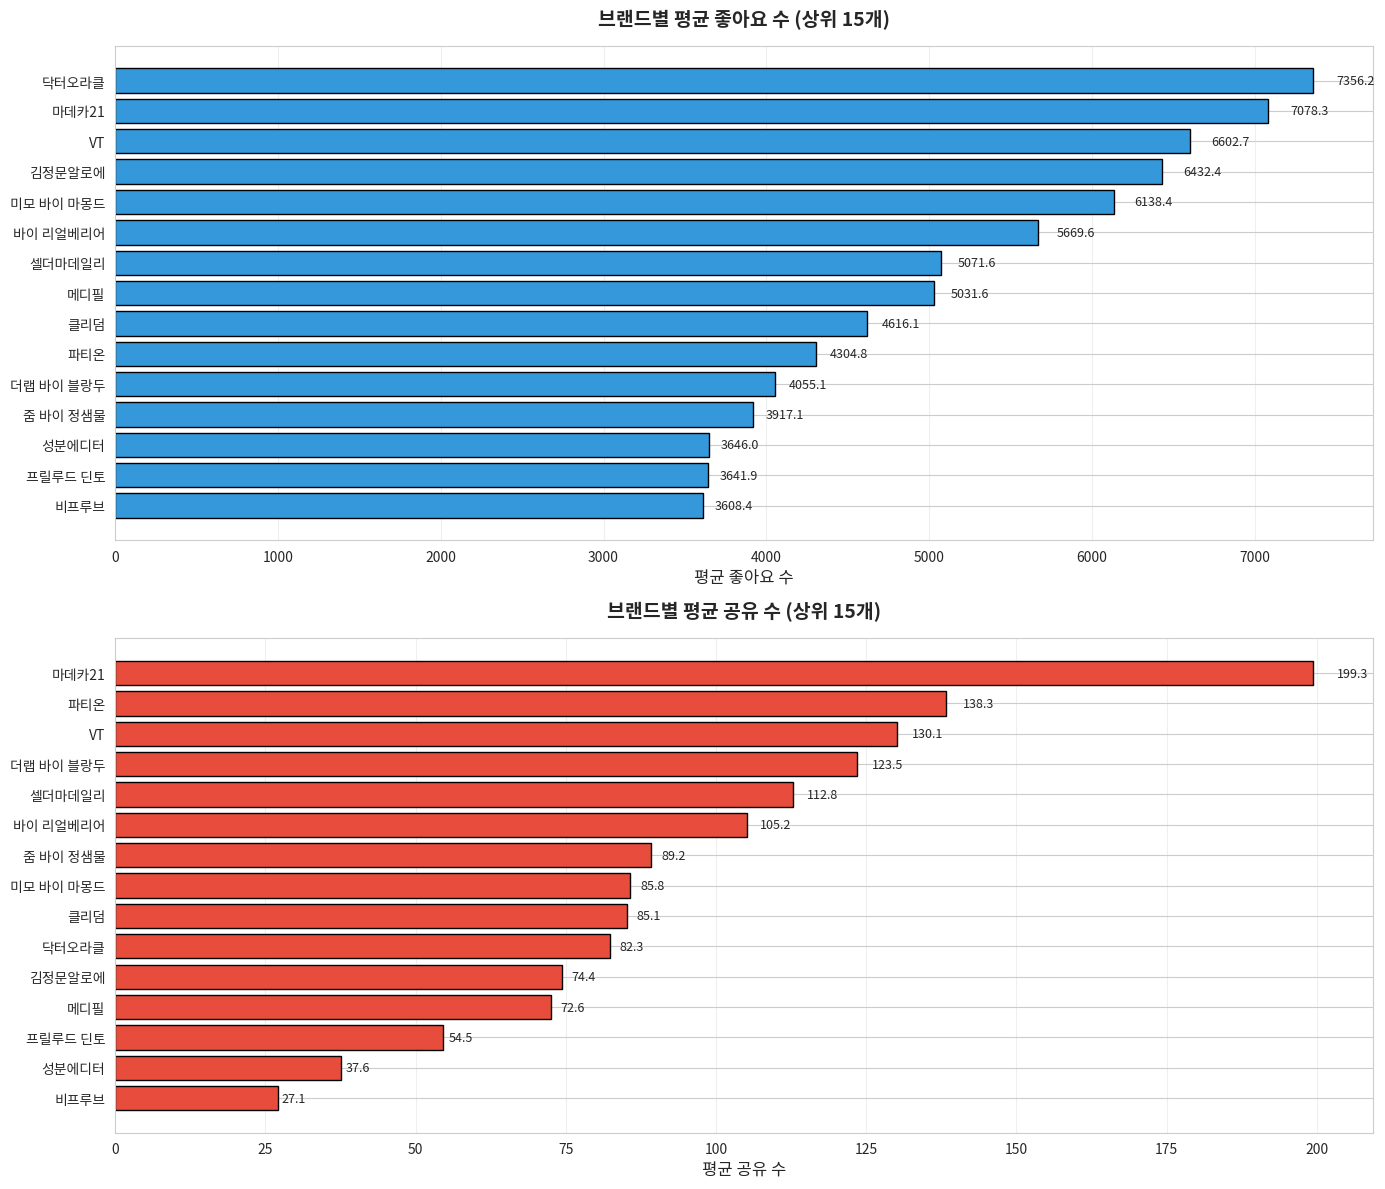

In [36]:
# 시각화: 브랜드별 좋아요/공유 비교
top_brands = brand_engagement_filtered.nlargest(15, '평균_좋아요').index

fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# 평균 좋아요
brand_likes = brand_engagement_filtered.loc[top_brands, '평균_좋아요'].sort_values()
axes[0].barh(range(len(brand_likes)), brand_likes.values, color='#3498DB', edgecolor='black')
axes[0].set_yticks(range(len(brand_likes)))
axes[0].set_yticklabels(brand_likes.index, fontsize=10)
axes[0].set_xlabel('평균 좋아요 수', fontsize=12)
axes[0].set_title('브랜드별 평균 좋아요 수 (상위 15개)', fontsize=14, fontweight='bold', pad=15)
axes[0].grid(axis='x', alpha=0.3)

for i, v in enumerate(brand_likes.values):
    axes[0].text(v + v*0.02, i, f'{v:.1f}', va='center', fontsize=9)

# 평균 공유
brand_shares = brand_engagement_filtered.loc[top_brands, '평균_공유'].sort_values()
axes[1].barh(range(len(brand_shares)), brand_shares.values, color='#E74C3C', edgecolor='black')
axes[1].set_yticks(range(len(brand_shares)))
axes[1].set_yticklabels(brand_shares.index, fontsize=10)
axes[1].set_xlabel('평균 공유 수', fontsize=12)
axes[1].set_title('브랜드별 평균 공유 수 (상위 15개)', fontsize=14, fontweight='bold', pad=15)
axes[1].grid(axis='x', alpha=0.3)

for i, v in enumerate(brand_shares.values):
    axes[1].text(v + v*0.02, i, f'{v:.1f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [37]:
# 좋아요/공유 비율 분석
brand_engagement_filtered['좋아요_공유_비율'] = (
    brand_engagement_filtered['평균_좋아요'] / (brand_engagement_filtered['평균_공유'] + 1)
)

print("\n좋아요/공유 비율이 높은 브랜드 (좋아요가 공유 대비 많음):")
print(brand_engagement_filtered.nlargest(10, '좋아요_공유_비율')[['평균_좋아요', '평균_공유', '좋아요_공유_비율', '제품_수']])

print("\n좋아요/공유 비율이 낮은 브랜드 (공유가 좋아요 대비 많음):")
print(brand_engagement_filtered.nsmallest(10, '좋아요_공유_비율')[['평균_좋아요', '평균_공유', '좋아요_공유_비율', '제품_수']])


좋아요/공유 비율이 높은 브랜드 (좋아요가 공유 대비 많음):
           평균_좋아요  평균_공유   좋아요_공유_비율  제품_수
brand                                     
레시피선몬랩    1532.67   4.33  287.555347     6
손앤박       2463.50  12.00  189.500000    26
랩잇        3195.60  20.00  152.171429     5
비프루브      3608.45  27.09  128.460306    11
네시픽       1006.20   7.00  125.775000     5
밀크터치 디어씽  1973.38  16.67  111.679683    21
드롭비       3000.15  26.81  107.880259    26
코코가가      2309.80  21.50  102.657778    10
코드글로컬러     363.25   2.58  101.466480    12
케어존 플러스   1761.30  16.60  100.073864    10

좋아요/공유 비율이 낮은 브랜드 (공유가 좋아요 대비 많음):
            평균_좋아요   평균_공유  좋아요_공유_비율  제품_수
brand                                      
KAI          11.60    0.40   8.285714     5
보닌           78.17    4.67  13.786596     6
쉬크          126.57    6.00  18.081429     7
AHC        1141.17   41.33  26.958894     6
싸이닉        1744.62   60.62  28.312561     8
프렙 바이 비레디   806.00   25.33  30.611470     6
파티온        4304.83  138.33  30.896648     6
더랩 바이 블랑두  4055.

## 9. 좋아요/공유가 특정 브랜드에서만 많이 관찰되는지

**분석 목적**:
- 소셜 engagement가 특정 브랜드에 집중되어 있는지 분석
- 집중도 지표(HHI)를 통해 정량화

In [38]:
# 좋아요/공유 집중도 분석
# 브랜드별 총 좋아요/공유
brand_total = products_df.groupby('brand').agg({
    'likes': 'sum',
    'shares': 'sum',
    'product_code': 'count'
}).rename(columns={'product_code': 'product_count'}).sort_values('likes', ascending=False)

# 전체 합계
total_likes = brand_total['likes'].sum()
total_shares = brand_total['shares'].sum()

# 누적 비율 계산
brand_total['likes_pct'] = (brand_total['likes'] / total_likes * 100).round(2)
brand_total['shares_pct'] = (brand_total['shares'] / total_shares * 100).round(2)
brand_total['likes_cum_pct'] = brand_total['likes_pct'].cumsum()
brand_total['shares_cum_pct'] = brand_total['shares_pct'].cumsum()

print("=== 좋아요/공유 집중도 분석 ===")
print(f"전체 좋아요: {total_likes:,}개")
print(f"전체 공유: {total_shares:,}개")
print(f"\n상위 10개 브랜드:")
print(brand_total.head(10)[['likes', 'likes_pct', 'likes_cum_pct', 'shares', 'shares_pct', 'shares_cum_pct']])

# 상위 N개 브랜드의 점유율
top_5_likes_pct = brand_total.head(5)['likes_pct'].sum()
top_10_likes_pct = brand_total.head(10)['likes_pct'].sum()
top_20_likes_pct = brand_total.head(20)['likes_pct'].sum()

top_5_shares_pct = brand_total.head(5)['shares_pct'].sum()
top_10_shares_pct = brand_total.head(10)['shares_pct'].sum()
top_20_shares_pct = brand_total.head(20)['shares_pct'].sum()

print(f"\n=== 집중도 지표 ===")
print(f"상위 5개 브랜드 좋아요 점유율: {top_5_likes_pct:.1f}%")
print(f"상위 10개 브랜드 좋아요 점유율: {top_10_likes_pct:.1f}%")
print(f"상위 20개 브랜드 좋아요 점유율: {top_20_likes_pct:.1f}%")
print(f"\n상위 5개 브랜드 공유 점유율: {top_5_shares_pct:.1f}%")
print(f"상위 10개 브랜드 공유 점유율: {top_10_shares_pct:.1f}%")
print(f"상위 20개 브랜드 공유 점유율: {top_20_shares_pct:.1f}%")

=== 좋아요/공유 집중도 분석 ===
전체 좋아요: 2,233,571개
전체 공유: 36,265개

상위 10개 브랜드:
          likes  likes_pct  likes_cum_pct  shares  shares_pct  shares_cum_pct
brand                                                                        
VT       145260       6.50           6.50    2861        7.89            7.89
태그       127648       5.71          12.21    1818        5.01           12.90
본셉       122675       5.49          17.70    3301        9.10           22.00
프릴루드 딘토  112898       5.05          22.75    1689        4.66           26.66
다이소       94343       4.22          26.97    1434        3.95           30.61
메디필       90568       4.05          31.02    1306        3.60           34.21
입큰        79028       3.54          34.56     838        2.31           36.52
드롭비       78004       3.49          38.05     697        1.92           38.44
클리덤       73858       3.31          41.36    1362        3.76           42.20
닥터오라클     73562       3.29          44.65     823        2.27           4

In [39]:
# HHI(Herfindahl-Hirschman Index) 계산
# HHI = 각 브랜드 점유율의 제곱의 합 (0~10000, 높을수록 집중도 높음)
hhi_likes = ((brand_total['likes_pct']) ** 2).sum()
hhi_shares = ((brand_total['shares_pct']) ** 2).sum()

print(f"\n=== HHI (Herfindahl-Hirschman Index) ===")
print(f"좋아요 HHI: {hhi_likes:.2f}")
print(f"공유 HHI: {hhi_shares:.2f}")
print(f"\nHHI 해석:")
print(f"  - 0~1500: 경쟁 시장")
print(f"  - 1500~2500: 중간 집중")
print(f"  - 2500 이상: 고도 집중")

if hhi_likes < 1500:
    print(f"\n좋아요는 여러 브랜드에 분산되어 있습니다 (경쟁 시장)")
elif hhi_likes < 2500:
    print(f"\n좋아요는 특정 브랜드에 중간 수준으로 집중되어 있습니다")
else:
    print(f"\n좋아요는 특정 브랜드에 고도로 집중되어 있습니다")


=== HHI (Herfindahl-Hirschman Index) ===
좋아요 HHI: 294.44
공유 HHI: 356.01

HHI 해석:
  - 0~1500: 경쟁 시장
  - 1500~2500: 중간 집중
  - 2500 이상: 고도 집중

좋아요는 여러 브랜드에 분산되어 있습니다 (경쟁 시장)


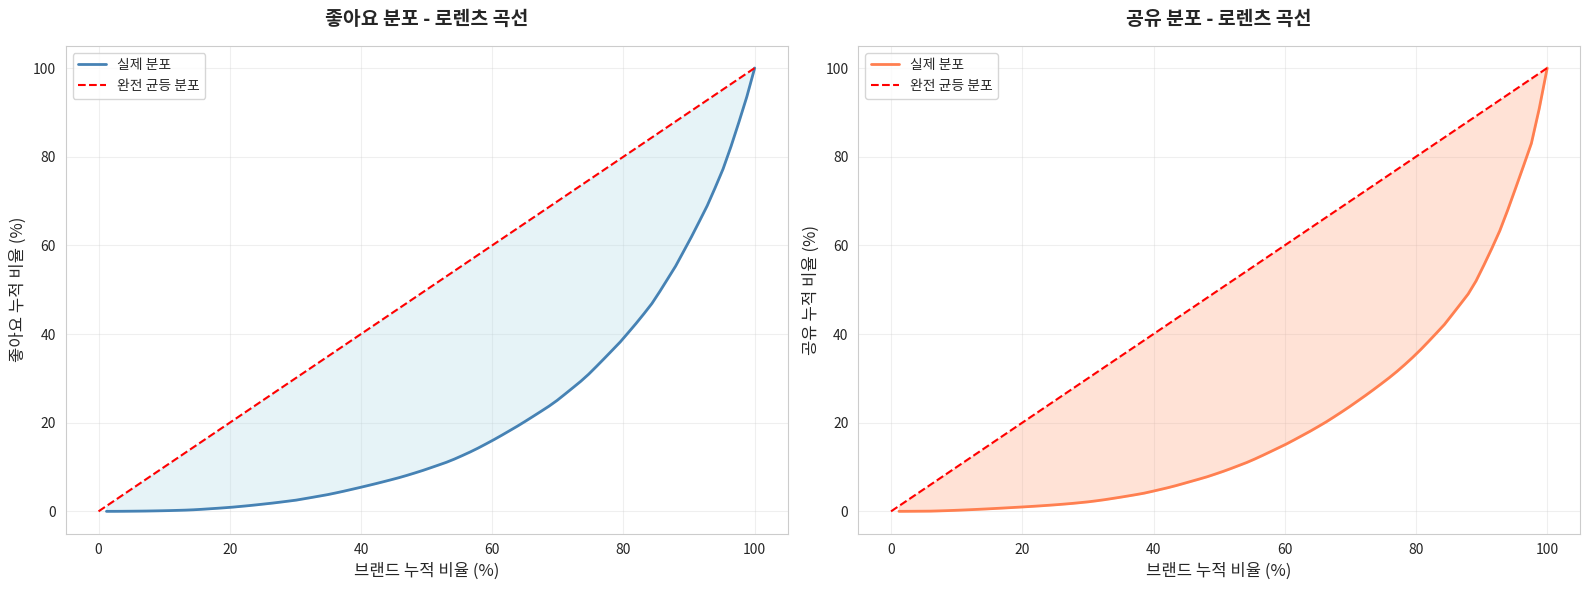

In [40]:
# 로렌츠 곡선 시각화 (Lorenz Curve)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 좋아요 로렌츠 곡선
brand_sorted_likes = brand_total.sort_values('likes')
cum_brands_likes = np.arange(1, len(brand_sorted_likes) + 1) / len(brand_sorted_likes) * 100
cum_likes_pct = (brand_sorted_likes['likes'].cumsum() / brand_sorted_likes['likes'].sum() * 100).values

axes[0].plot(cum_brands_likes, cum_likes_pct, color='steelblue', linewidth=2, label='실제 분포')
axes[0].plot([0, 100], [0, 100], 'r--', linewidth=1.5, label='완전 균등 분포')
axes[0].fill_between(cum_brands_likes, cum_likes_pct, cum_brands_likes, alpha=0.3, color='lightblue')
axes[0].set_xlabel('브랜드 누적 비율 (%)', fontsize=12)
axes[0].set_ylabel('좋아요 누적 비율 (%)', fontsize=12)
axes[0].set_title('좋아요 분포 - 로렌츠 곡선', fontsize=14, fontweight='bold', pad=15)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 공유 로렌츠 곡선
brand_sorted_shares = brand_total.sort_values('shares')
cum_brands_shares = np.arange(1, len(brand_sorted_shares) + 1) / len(brand_sorted_shares) * 100
cum_shares_pct = (brand_sorted_shares['shares'].cumsum() / brand_sorted_shares['shares'].sum() * 100).values

axes[1].plot(cum_brands_shares, cum_shares_pct, color='coral', linewidth=2, label='실제 분포')
axes[1].plot([0, 100], [0, 100], 'r--', linewidth=1.5, label='완전 균등 분포')
axes[1].fill_between(cum_brands_shares, cum_shares_pct, cum_brands_shares, alpha=0.3, color='lightsalmon')
axes[1].set_xlabel('브랜드 누적 비율 (%)', fontsize=12)
axes[1].set_ylabel('공유 누적 비율 (%)', fontsize=12)
axes[1].set_title('공유 분포 - 로렌츠 곡선', fontsize=14, fontweight='bold', pad=15)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. 재구매율 30% 이상 제품의 특징

**분석 목적**:
- 재구매율이 높은 제품들의 공통 특징 파악
- 어떤 카테고리, 가격대, 브랜드가 재구매율이 높은지 분석

In [41]:
# 제품별 재구매율 계산
product_reorder_stats = reviews_df.groupby('product_code').agg({
    'is_reorder': ['sum', 'count'],
    'rating': 'mean'
})

product_reorder_stats.columns = ['재구매_리뷰수', '전체_리뷰수', '평균_평점']
product_reorder_stats['재구매율'] = (
    product_reorder_stats['재구매_리뷰수'] / product_reorder_stats['전체_리뷰수'] * 100
).round(2)

# 제품 정보와 병합
product_reorder_stats = product_reorder_stats.reset_index()
product_reorder_analysis = products_df.merge(product_reorder_stats, on='product_code', how='left')

# 재구매율 30% 이상, 리뷰 20개 이상 제품
high_reorder = product_reorder_analysis[
    (product_reorder_analysis['재구매율'] >= 30) &
    (product_reorder_analysis['전체_리뷰수'] >= 20)
].copy()

print(f"=== 재구매율 30% 이상 제품 분석 ===")
print(f"조건을 만족하는 제품: {len(high_reorder)}개")
print(f"\n상위 20개 제품:")
print(high_reorder.nlargest(20, '재구매율')[['name', '재구매율', '전체_리뷰수', '평균_평점', 'price', 'brand']])

=== 재구매율 30% 이상 제품 분석 ===
조건을 만족하는 제품: 118개

상위 20개 제품:
                                         name   재구매율  전체_리뷰수     평균_평점  price  \
809         VT 리들샷 300 페이셜 부스팅 퍼스트 앰플 2ml*6개입  66.09  9869.0  4.903232   3000   
810         VT 리들샷 100 페이셜 부스팅 퍼스트 앰플 2ml*6개입  62.54  9815.0  4.896994   3000   
755                        6중날 오픈 카트리지 면도기 1P  58.14    43.0  4.837209   1000   
138                    본셉 비타씨 동결 건조 더블샷 앰플 키트  55.44  5839.0  4.788491   5000   
748                         러블리 메이크업 리퀴드아이라이너  54.67    75.0  4.586667   2000   
808         VT 리들샷 500 페이셜 부스팅 퍼스트 앰플 2ml*8개입  51.29  3254.0  4.820836   5000   
806            VT 리들샷 페이셜 리페어 EGF 에센스 2ml*6개입  50.66  1591.0  4.796354   3000   
62                          팩미인 하이드로겔 브이 마스크팩  50.41  2710.0  4.681181   1000   
530               셀더마데일리 트랜스포밍 아줄렌카밍 마스크 28 g  48.99  2268.0  4.733245   2000   
799     VT 콜라겐 리들샷 S50 페이셜 부스팅 퍼스트 앰플 2ml*6개입  45.65  3284.0  4.820341   3000   
122  CNP bye od-td 비타 카밍 세럼 2 ml 7개입 (LG생활건강)  45.28 

In [42]:
# 재구매율 30% 이상 제품의 특징 분석
print("\n=== 카테고리별 분포 ===")
category_dist = high_reorder['category_2'].value_counts().head(10)
print(category_dist)

print("\n=== 브랜드별 분포 ===")
brand_dist = high_reorder['brand'].value_counts().head(10)
print(brand_dist)

print("\n=== 가격대 분석 ===")
price_stats = high_reorder['price'].describe()
print(price_stats)

print(f"\n평균 가격: {high_reorder['price'].mean():,.0f}원")
print(f"중앙값 가격: {high_reorder['price'].median():,.0f}원")

print("\n=== 평점 분석 ===")
print(f"평균 평점: {high_reorder['평균_평점'].mean():.2f}점")
print(f"평점 4.5 이상 비율: {(high_reorder['평균_평점'] >= 4.5).mean() * 100:.1f}%")


=== 카테고리별 분포 ===
category_2
기초스킨케어     72
팩/마스크      16
자외선차단제      7
클렌징/필링      6
아이메이크업      5
남성용면도기      5
남성스킨케어      3
클렌징/쉐이빙     1
립케어         1
립메이크업       1
Name: count, dtype: int64

=== 브랜드별 분포 ===
brand
VT        15
다이소       13
마데카21      7
본셉         7
닥터오라클      6
제이엠솔루션     5
클리덤        5
비프루브       5
도루코        4
셀더마데일리     4
Name: count, dtype: int64

=== 가격대 분석 ===
count     118.000000
mean     3728.813559
std      1485.893883
min       500.000000
25%      3000.000000
50%      5000.000000
75%      5000.000000
max      5000.000000
Name: price, dtype: float64

평균 가격: 3,729원
중앙값 가격: 5,000원

=== 평점 분석 ===
평균 평점: 4.78점
평점 4.5 이상 비율: 100.0%


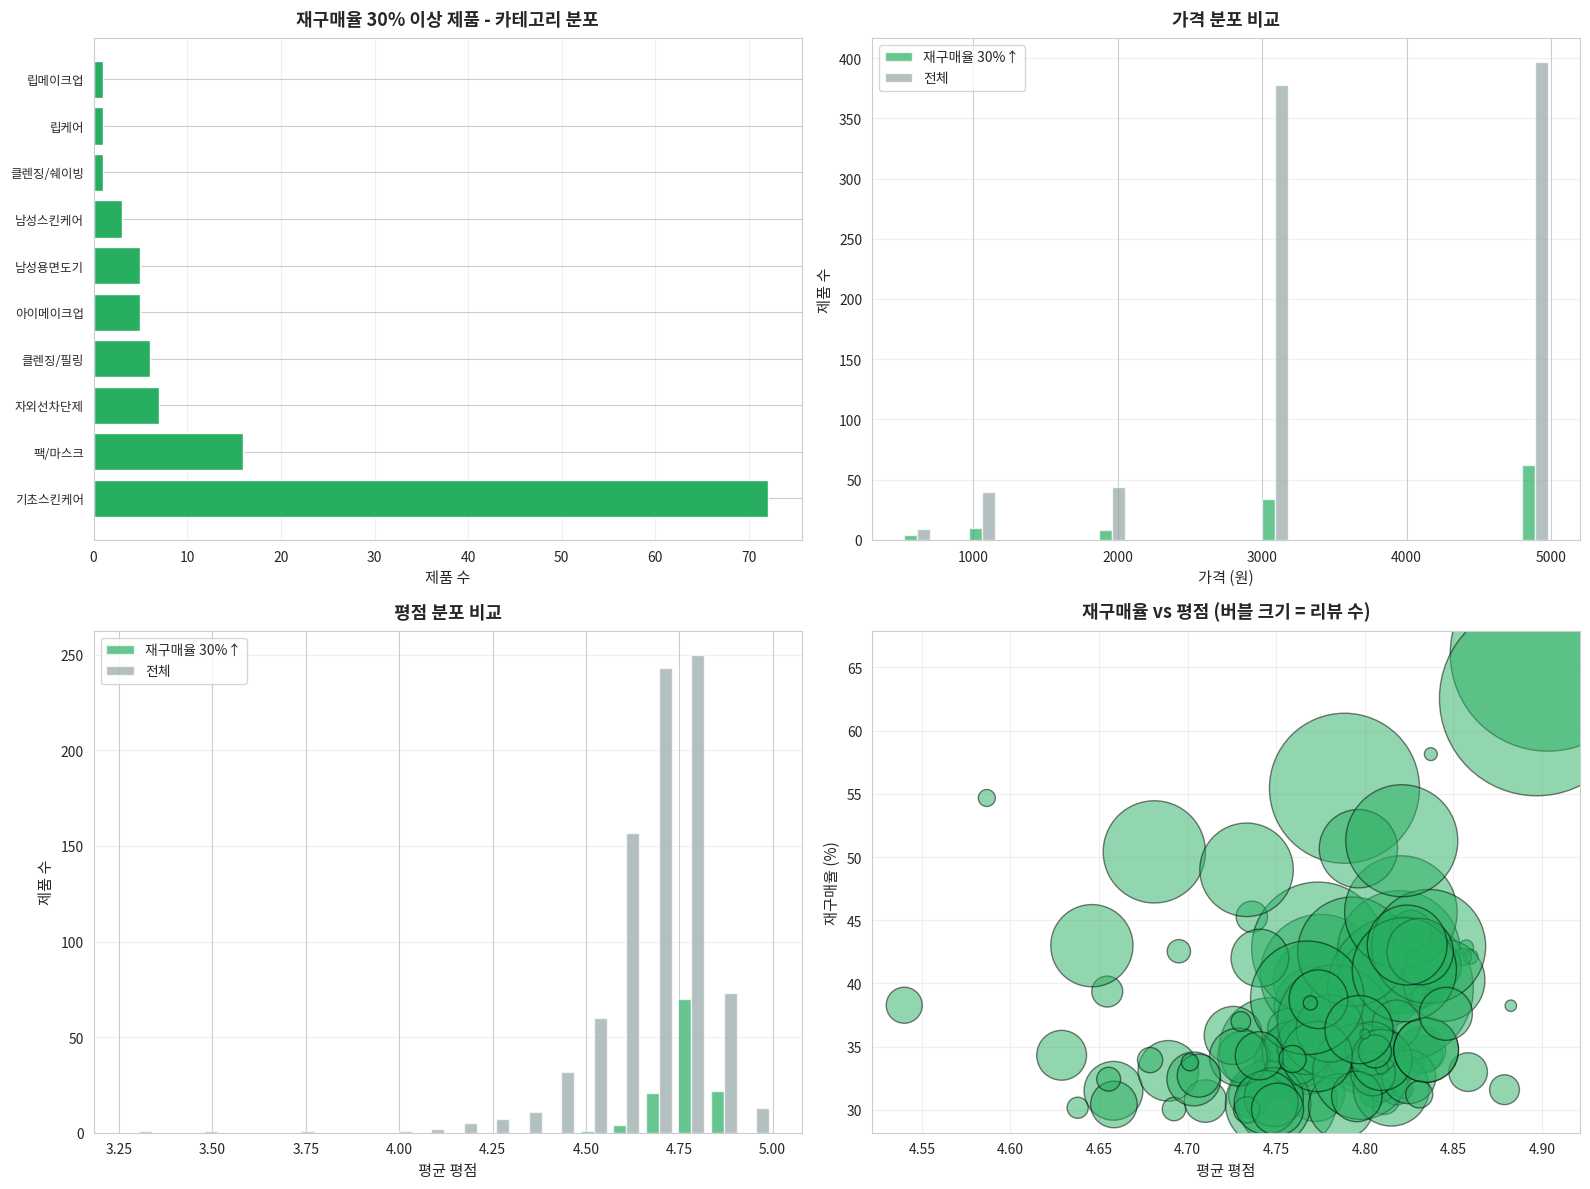

In [43]:
# 재구매율 30% 이상 vs 전체 제품 비교
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 카테고리 비교
top_categories_high = high_reorder['category_2'].value_counts().head(10)
top_categories_all = products_df['category_2'].value_counts().head(10)

axes[0, 0].barh(range(len(top_categories_high)), top_categories_high.values, color='#27AE60', label='재구매율 30%↑')
axes[0, 0].set_yticks(range(len(top_categories_high)))
axes[0, 0].set_yticklabels(top_categories_high.index, fontsize=9)
axes[0, 0].set_xlabel('제품 수', fontsize=11)
axes[0, 0].set_title('재구매율 30% 이상 제품 - 카테고리 분포', fontsize=13, fontweight='bold', pad=10)
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. 가격 분포
axes[0, 1].hist([high_reorder['price'], products_df['price']],
                bins=20, label=['재구매율 30%↑', '전체'], alpha=0.7, color=['#27AE60', '#95A5A6'])
axes[0, 1].set_xlabel('가격 (원)', fontsize=11)
axes[0, 1].set_ylabel('제품 수', fontsize=11)
axes[0, 1].set_title('가격 분포 비교', fontsize=13, fontweight='bold', pad=10)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. 평점 분포
axes[1, 0].hist([high_reorder['평균_평점'], product_reorder_analysis['평균_평점'].dropna()],
                bins=20, label=['재구매율 30%↑', '전체'], alpha=0.7, color=['#27AE60', '#95A5A6'])
axes[1, 0].set_xlabel('평균 평점', fontsize=11)
axes[1, 0].set_ylabel('제품 수', fontsize=11)
axes[1, 0].set_title('평점 분포 비교', fontsize=13, fontweight='bold', pad=10)
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. 재구매율 vs 평점 산점도
axes[1, 1].scatter(high_reorder['평균_평점'], high_reorder['재구매율'],
                  s=high_reorder['전체_리뷰수']*2, alpha=0.5, c='#27AE60', edgecolors='black')
axes[1, 1].set_xlabel('평균 평점', fontsize=11)
axes[1, 1].set_ylabel('재구매율 (%)', fontsize=11)
axes[1, 1].set_title('재구매율 vs 평점 (버블 크기 = 리뷰 수)', fontsize=13, fontweight='bold', pad=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 10-1. 소분류 카테고리별 재구매율 분석

**분석 목적**:
- 소분류 카테고리(category_2)별 재구매율 비교
- 재구매가 잘 일어나는 카테고리 vs 그렇지 않은 카테고리 파악

**기대 결과**:
- 카테고리별 재구매 특성 이해
- 제품 특성에 따른 재구매 패턴 파악

In [ ]:
# 카테고리별 재구매율 계산
category_reorder_stats = product_reorder_analysis.groupby('category_2').agg({
    '재구매_리뷰수': 'sum',
    '전체_리뷰수': 'sum',
    'product_code': 'count'
}).rename(columns={'product_code': '제품_수'})

category_reorder_stats['재구매율'] = (
    category_reorder_stats['재구매_리뷰수'] / category_reorder_stats['전체_리뷰수'] * 100
).round(2)

# 리뷰가 50개 이상인 카테고리만 분석 (신뢰도 확보)
category_reorder_stats_filtered = category_reorder_stats[
    category_reorder_stats['전체_리뷰수'] >= 50
].sort_values('재구매율', ascending=False)

print("=== 소분류 카테고리별 재구매율 (리뷰 50개 이상) ===")
print(category_reorder_stats_filtered.head(20))

print(f"\n분석 대상 카테고리: {len(category_reorder_stats_filtered)}개")
print(f"평균 재구매율: {category_reorder_stats_filtered['재구매율'].mean():.2f}%")
print(f"중앙값 재구매율: {category_reorder_stats_filtered['재구매율'].median():.2f}%")

In [ ]:
# 카테고리별 재구매율 시각화
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. 재구매율 상위 15개 카테고리
top_15_reorder = category_reorder_stats_filtered.nlargest(15, '재구매율')

axes[0, 0].barh(range(len(top_15_reorder)), top_15_reorder['재구매율'].values,
                color='#27AE60', edgecolor='black', linewidth=1.5)
axes[0, 0].set_yticks(range(len(top_15_reorder)))
axes[0, 0].set_yticklabels(top_15_reorder.index, fontsize=10)
axes[0, 0].set_xlabel('재구매율 (%)', fontsize=11)
axes[0, 0].set_title('재구매율 상위 15개 카테고리', fontsize=13, fontweight='bold', pad=15)
axes[0, 0].grid(axis='x', alpha=0.3)

for i, v in enumerate(top_15_reorder['재구매율'].values):
    axes[0, 0].text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=9)

# 2. 재구매율 하위 15개 카테고리
bottom_15_reorder = category_reorder_stats_filtered.nsmallest(15, '재구매율')

axes[0, 1].barh(range(len(bottom_15_reorder)), bottom_15_reorder['재구매율'].values,
                color='#E74C3C', edgecolor='black', linewidth=1.5)
axes[0, 1].set_yticks(range(len(bottom_15_reorder)))
axes[0, 1].set_yticklabels(bottom_15_reorder.index, fontsize=10)
axes[0, 1].set_xlabel('재구매율 (%)', fontsize=11)
axes[0, 1].set_title('재구매율 하위 15개 카테고리', fontsize=13, fontweight='bold', pad=15)
axes[0, 1].grid(axis='x', alpha=0.3)

for i, v in enumerate(bottom_15_reorder['재구매율'].values):
    axes[0, 1].text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=9)

# 3. 카테고리별 재구매율 vs 제품 수 (버블 차트)
scatter = axes[1, 0].scatter(
    category_reorder_stats_filtered['제품_수'],
    category_reorder_stats_filtered['재구매율'],
    s=category_reorder_stats_filtered['전체_리뷰수'] / 10,  # 버블 크기 = 리뷰 수
    alpha=0.6,
    c=category_reorder_stats_filtered['재구매율'],
    cmap='RdYlGn',
    edgecolors='black',
    linewidth=1
)

axes[1, 0].set_xlabel('제품 수', fontsize=11)
axes[1, 0].set_ylabel('재구매율 (%)', fontsize=11)
axes[1, 0].set_title('카테고리별 제품 수 vs 재구매율\n(버블 크기 = 총 리뷰 수)',
                     fontsize=13, fontweight='bold', pad=15)
axes[1, 0].grid(True, alpha=0.3)

# 상위 5개 카테고리 레이블
for category in top_15_reorder.head(5).index:
    if category in category_reorder_stats_filtered.index:
        row = category_reorder_stats_filtered.loc[category]
        axes[1, 0].annotate(
            category[:15] + '...' if len(category) > 15 else category,
            xy=(row['제품_수'], row['재구매율']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=8,
            alpha=0.8
        )

cbar = plt.colorbar(scatter, ax=axes[1, 0])
cbar.set_label('재구매율 (%)', fontsize=10)

# 4. 카테고리별 평균 재구매 횟수 (재구매 리뷰 수 / 제품 수)
category_reorder_stats_filtered['평균_재구매_리뷰'] = (
    category_reorder_stats_filtered['재구매_리뷰수'] / category_reorder_stats_filtered['제품_수']
).round(2)

top_15_avg_reorder = category_reorder_stats_filtered.nlargest(15, '평균_재구매_리뷰')

axes[1, 1].barh(range(len(top_15_avg_reorder)), top_15_avg_reorder['평균_재구매_리뷰'].values,
                color='#3498DB', edgecolor='black', linewidth=1.5)
axes[1, 1].set_yticks(range(len(top_15_avg_reorder)))
axes[1, 1].set_yticklabels(top_15_avg_reorder.index, fontsize=10)
axes[1, 1].set_xlabel('제품당 평균 재구매 리뷰 수', fontsize=11)
axes[1, 1].set_title('제품당 평균 재구매 리뷰 수 상위 15개 카테고리',
                     fontsize=13, fontweight='bold', pad=15)
axes[1, 1].grid(axis='x', alpha=0.3)

for i, v in enumerate(top_15_avg_reorder['평균_재구매_리뷰'].values):
    axes[1, 1].text(v + v*0.02, i, f'{v:.1f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# 카테고리 그룹별 분석
# 재구매율 기준으로 3그룹 분류

reorder_rate_high_threshold = category_reorder_stats_filtered['재구매율'].quantile(0.67)
reorder_rate_low_threshold = category_reorder_stats_filtered['재구매율'].quantile(0.33)

print(f"재구매율 기준:")
print(f"  상위 그룹: {reorder_rate_high_threshold:.2f}% 이상")
print(f"  중간 그룹: {reorder_rate_low_threshold:.2f}% ~ {reorder_rate_high_threshold:.2f}%")
print(f"  하위 그룹: {reorder_rate_low_threshold:.2f}% 미만")

# 그룹 분류
def classify_reorder_group(rate):
    if rate >= reorder_rate_high_threshold:
        return '고재구매'
    elif rate >= reorder_rate_low_threshold:
        return '중재구매'
    else:
        return '저재구매'

category_reorder_stats_filtered['재구매_그룹'] = category_reorder_stats_filtered['재구매율'].apply(
    classify_reorder_group
)

# 그룹별 통계
group_stats = category_reorder_stats_filtered.groupby('재구매_그룹').agg({
    'category_2': 'count',
    '재구매율': 'mean',
    '전체_리뷰수': 'mean',
    '제품_수': 'mean'
}).rename(columns={'category_2': '카테고리_수'})

print(f"\n=== 재구매율 그룹별 통계 ===")
print(group_stats.round(2))

# 각 그룹 대표 카테고리
print(f"\n=== 각 그룹 대표 카테고리 ===")

for group in ['고재구매', '중재구매', '저재구매']:
    group_categories = category_reorder_stats_filtered[
        category_reorder_stats_filtered['재구매_그룹'] == group
    ].sort_values('전체_리뷰수', ascending=False).head(5)

    print(f"\n[{group}] (상위 5개):")
    for idx, row in group_categories.iterrows():
        print(f"  - {idx}: 재구매율 {row['재구매율']:.1f}%, 리뷰 {row['전체_리뷰수']:.0f}개, 제품 {row['제품_수']:.0f}개")

## 11. 재구매율 5% 미만 제품의 특징

**분석 목적**:
- 재구매율이 낮은 제품들의 공통 특징 파악
- 재구매를 저해하는 요인 분석

**기대 결과**:
- 재구매 실패 요인 발굴
- 개선이 필요한 제품 패턴 이해

In [44]:
# 재구매율 5% 미만 제품 분석

low_reorder = product_reorder_analysis[
    (product_reorder_analysis['재구매율'] < 10) &
    (product_reorder_analysis['전체_리뷰수'] >= 20)
].copy()

print(f"=== 재구매율 10% 미만 제품 분석 ===")
print(f"조건을 만족하는 제품: {len(low_reorder)}개")
print(f"\n재구매율이 가장 낮은 20개 제품:")
print(low_reorder.nsmallest(20, '재구매율')[['name', '재구매율', '전체_리뷰수', '평균_평점', 'price', 'brand', 'category_2']])

=== 재구매율 10% 미만 제품 분석 ===
조건을 만족하는 제품: 145개

재구매율이 가장 낮은 20개 제품:
                                               name  재구매율  전체_리뷰수     평균_평점  \
188                   [02 허니피치]트윙클팝 탱글 젤링 팟 by CLIO  0.00    45.0  4.844444   
318                 이즈앤트리 어니언블레미쉬 퍼플라이트 톤업선크림 40 ml  0.00    32.0  4.718750   
336                    성분에디터 머루포도 비타씨 브라이트닝 파우더 5 g  0.00    32.0  4.593750   
337                 성분에디터 머루포도 비타씨 다크스팟 크림플레인 35 ml  0.00    26.0  4.769231   
359              [01 허니빔]밀크터치 디어씽 글로우 이펙트 리퀴드 하이라이터  0.00    20.0  4.550000   
414              투에딧 바이 루나 [02 내추럴]투에딧 밀착커버 컨실러 X세숑  0.00    22.0  4.590909   
415          투에딧 바이 루나 [01 라이트]투에딧 반질커버 쿠션 13 g X세숑  0.00    46.0  4.869565   
673                      더랩바이블랑두 클리어히알결광 젤클렌저 100 g  0.00    43.0  4.744186   
737                                     전동 코털정리기 세트  0.00    44.0  4.204545   
386                           포인트 라이스 찰떡흡착 클렌징폼 80g  1.67    60.0  4.666667   
563             메디필 락토 모공 리프팅 패드 2.0 리필 (190ml/70매)  2.17    46.0 

In [45]:
# 재구매율 10% 미만 제품의 특징 분석

print("\n=== 카테고리별 분포 ===")
category_dist_low = low_reorder['category_2'].value_counts().head(10)
print(category_dist_low)

print("\n=== 브랜드별 분포 ===")
brand_dist_low = low_reorder['brand'].value_counts().head(10)
print(brand_dist_low)

print("\n=== 가격대 분석 ===")
price_stats_low = low_reorder['price'].describe()
print(price_stats_low)

print(f"\n평균 가격: {low_reorder['price'].mean():,.0f}원")
print(f"중앙값 가격: {low_reorder['price'].median():,.0f}원")

print("\n=== 평점 분석 ===")
print(f"평균 평점: {low_reorder['평균_평점'].mean():.2f}점")
print(f"평점 3.5 이하 비율: {(low_reorder['평균_평점'] <= 3.5).mean() * 100:.1f}%")


=== 카테고리별 분포 ===
category_2
치크/하이라이터    32
베이스메이크업     30
립메이크업       23
아이메이크업      22
기초스킨케어      18
클렌징/필링       6
립케어          5
자외선차단제       3
남성용면도기       3
팩/마스크        2
Name: count, dtype: int64

=== 브랜드별 분포 ===
brand
투에딧              12
태그               11
밀크터치 디어씽          8
본셉                8
트윙클팝              8
코시에로              8
줌 바이 정샘물          8
플레이101 by 에뛰드     7
코드글로컬러            7
프릴루드 딘토           7
Name: count, dtype: int64

=== 가격대 분석 ===
count     145.000000
mean     3848.275862
std      1132.420187
min      1000.000000
25%      3000.000000
50%      3000.000000
75%      5000.000000
max      5000.000000
Name: price, dtype: float64

평균 가격: 3,848원
중앙값 가격: 3,000원

=== 평점 분석 ===
평균 평점: 4.63점
평점 3.5 이하 비율: 0.0%


In [46]:
# 재구매율 고vs저 비교 테이블
comparison = pd.DataFrame({
    '지표': ['제품 수', '평균 가격', '평균 평점', '평균 리뷰 수'],
    '재구매율 30%↑': [
        len(high_reorder),
        f"{high_reorder['price'].mean():,.0f}원",
        f"{high_reorder['평균_평점'].mean():.2f}점",
        f"{high_reorder['전체_리뷰수'].mean():.1f}개"
    ],
    '재구매율 10%↓': [
        len(low_reorder),
        f"{low_reorder['price'].mean():,.0f}원",
        f"{low_reorder['평균_평점'].mean():.2f}점",
        f"{low_reorder['전체_리뷰수'].mean():.1f}개"
    ]
})

print("\n=== 재구매율 고 vs 저 비교 ===")
print(comparison.to_string(index=False))

# 가격 차이 통계 검정
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(high_reorder['price'], low_reorder['price'])
print(f"\n가격 차이 Mann-Whitney U 검정:")
print(f"  U-통계량: {stat:.2f}")
print(f"  p-value: {p_value:.6f}")
if p_value < 0.05:
    print("  결론: 두 그룹 간 가격 차이가 통계적으로 유의합니다")
else:
    print("  결론: 두 그룹 간 가격 차이가 통계적으로 유의하지 않습니다")

# 평점 차이 검정
stat2, p_value2 = mannwhitneyu(high_reorder['평균_평점'].dropna(), low_reorder['평균_평점'].dropna())
print(f"\n평점 차이 Mann-Whitney U 검정:")
print(f"  U-통계량: {stat2:.2f}")
print(f"  p-value: {p_value2:.6f}")
if p_value2 < 0.05:
    print("  결론: 두 그룹 간 평점 차이가 통계적으로 유의합니다")
else:
    print("  결론: 두 그룹 간 평점 차이가 통계적으로 유의하지 않습니다")


=== 재구매율 고 vs 저 비교 ===
     지표 재구매율 30%↑ 재구매율 10%↓
   제품 수       118       145
  평균 가격    3,729원    3,848원
  평균 평점     4.78점     4.63점
평균 리뷰 수   1223.3개     88.4개

가격 차이 Mann-Whitney U 검정:
  U-통계량: 8410.00
  p-value: 0.794341
  결론: 두 그룹 간 가격 차이가 통계적으로 유의하지 않습니다

평점 차이 Mann-Whitney U 검정:
  U-통계량: 13875.50
  p-value: 0.000000
  결론: 두 그룹 간 평점 차이가 통계적으로 유의합니다


## 12. 1점 리뷰 텍스트 마이닝

**분석 목적**:
- 1점 리뷰의 주요 불만 사항 파악
- 키워드 분석을 통해 개선이 필요한 영역 식별

### 12.1. 1점 리뷰 키워드 분석

In [47]:
# 1점 리뷰 추출

low_rating_reviews = reviews_df[reviews_df['rating'] == 1].copy()

print(f"=== 1점 리뷰 분석 ===")
print(f"전체 리뷰 수: {len(reviews_df):,}개")
print(f"1점 리뷰 수: {len(low_rating_reviews):,}개 ({len(low_rating_reviews)/len(reviews_df)*100:.2f}%)")
print(f"\n1점 리뷰 샘플 (상위 10개):")
for idx, (i, row) in enumerate(low_rating_reviews.head(10).iterrows(), 1):
    text = row['text'][:100] if pd.notna(row['text']) else ''
    print(f"{idx}. {text}...")

=== 1점 리뷰 분석 ===
전체 리뷰 수: 312,139개
1점 리뷰 수: 2,082개 (0.67%)

1점 리뷰 샘플 (상위 10개):
1. 재구매 매장에 재고가 없어서 온라인몰에 첫주문 했는데 퍼프가 없네요 황당;;별하나도 아깝습니다. 다이소 물건 오래 주문했지만 이런 경우도 다 있네요....
2. 이거 발색 되는거 맞나요? 저는 왜 발색이 안되는거 같죠? 바쁜 아침시간 한두번 사용해보다 결국에 기존에 사용하던 제품으로 화장하고 출근했어요 저는 비추입니다....
3. 솔찌기말해서. 굳이 다이소에서 판다면 천원해도 무방할것같다. 냄새 욕나올정도로 이상한 냄새나고 반품하고싶돠 절대 어윽놉놉 뷰티엔손대지말좌 양심있음...
4. 좋아요 😀 잘사용중 입니다....
5. 좋아요 😀 잘사용중 입니다....
6. 잘 안 그려져요. 괜히 샀어요...
7. 음......저처럼 피부에 조금만 안맞으면 좁쌀여드름 또는 뾰로지 나시는분들껜 진짜 비추요..ㅎㅎ
피부가 다 뒤집어져서 팩하면서 복구중인데 너무 안돌아와요 헝 ㅠㅠ...
8. 별로에요 날이 잘 안드는거 같다고 하네요
잘 안된대요...
9. 배송이 왔는데 부러져서 왔고 교환하려니까 교환 배송비같은거 나오면서 6천원이나 때가고 나중에 돌려준다 그러는데 그럴거면 돈을 왜 가져가는지 모르겠지만 발색 좋다:)...
10. 제품을 사용해보니 피부에 너무 끈적끈적한 느낌이 들어서 영 기분이 안좋네요 비추천합니다...


**분석 목적**:
- 1점 리뷰를 의미 카테고리별로 분류하여 불만 유형 파악
- 정규표현식 패턴 매칭을 통한 체계적 분석

**분석 방법**:
1. RQ/utils/keyword_analysis.py의 KEYWORD_CATEGORIES 활용
2. 품질[부정], 편의[부정], 심미[부정], 물류[부정] 카테고리 분석
3. 카테고리별 빈도 계산 및 시각화

In [48]:
# 1점 리뷰 텍스트 전처리 (형태소 분석)

print("\n1점 리뷰 토큰화 진행 중")

# 텍스트 리스트 추출
low_rating_texts = low_rating_reviews['text'].fillna('').tolist()

# 토큰화 (명사, 형용사 추출)
low_rating_tokens_list = tokenize_reviews(
    low_rating_texts[:1000],  # 샘플 1000개로 제한 (시간 절약)
    extract_pos=['Noun', 'Adjective'],
    remove_stop=True,
    verbose=True
)

# 전체 토큰 합치기
all_low_rating_tokens = []
for tokens in low_rating_tokens_list:
    all_low_rating_tokens.extend(tokens)

print(f"\n추출된 토큰 수: {len(all_low_rating_tokens):,}개")
print(f"고유 토큰 수: {len(set(all_low_rating_tokens)):,}개")


1점 리뷰 토큰화 진행 중
진행중: 1000/1000 (100.0%)
완료: 1000개 리뷰 토큰화

추출된 토큰 수: 8,030개
고유 토큰 수: 1,889개


In [49]:
# 1점 리뷰 키워드 빈도 분석

from utils.keyword_analysis import calculate_keyword_frequency

# 키워드 빈도 계산
low_rating_freq = calculate_keyword_frequency(low_rating_tokens_list, top_n=50)

print("=== 1점 리뷰 상위 키워드 ===")
print(low_rating_freq.head(30))

=== 1점 리뷰 상위 키워드 ===
   keyword  frequency
0       없다        168
1       좋다        164
2       배송        138
3       제품        130
4       사용        112
5       피부        112
6      아니다        102
7       상품         83
8      다이소         71
9       교환         70
10     안되다         68
11      발색         67
12      주문         61
13      입술         61
14      구매         57
15      얼굴         56
16      효과         56
17     그렇다         54
18    건조하다         51
19      생각         50
20      냄새         48
21      느낌         47
22      전혀         41
23      택배         41
24      다른         39
25      하나         38
26      문의         38
27     심하다         36
28    촉촉하다         35
29      리뷰         32


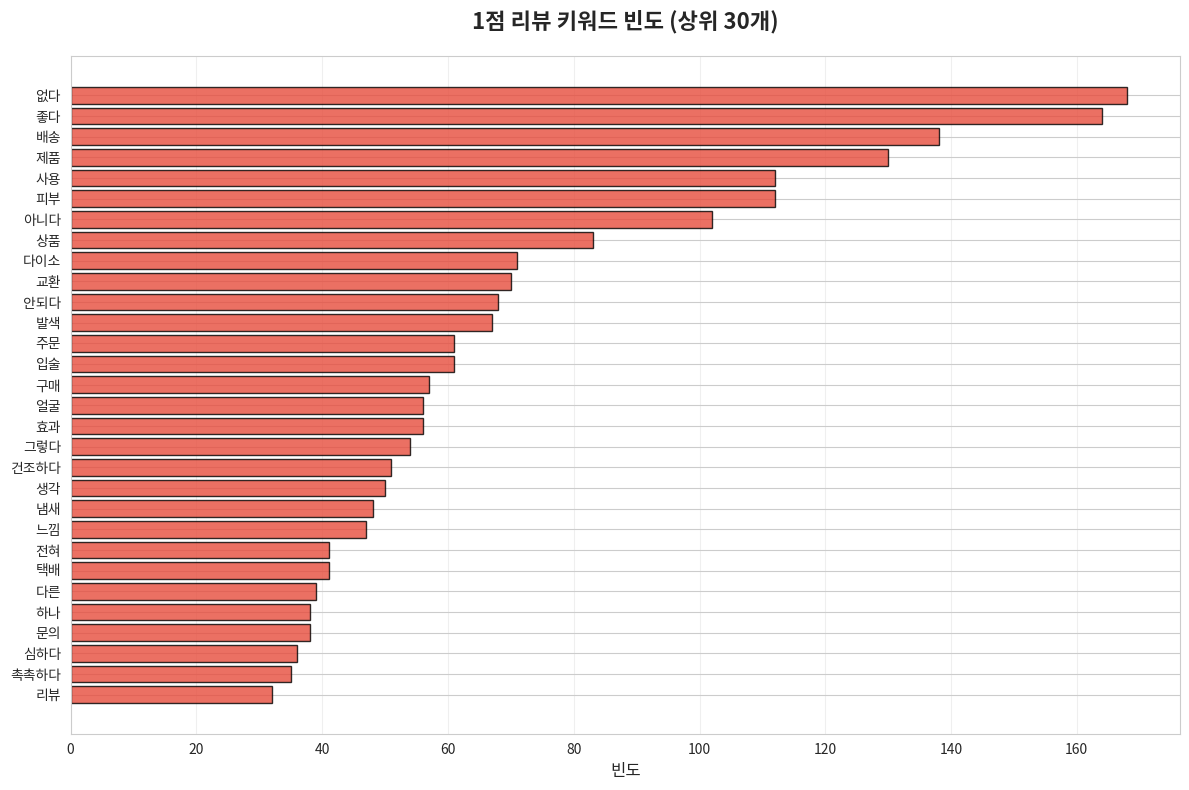

In [50]:
# 시각화
plot_keyword_frequency(
    low_rating_freq,
    title='1점 리뷰 키워드 빈도 (상위 30개)',
    top_n=30,
    color='#E74C3C',
    horizontal=True
)

### 12.2. 1점 리뷰 카테고리 분석

**분석 목적**:
- 1점 리뷰와 5점 리뷰의 키워드를 시각적으로 비교
- 부정/긍정 리뷰의 차이점 직관적 이해

In [51]:
# 1점 리뷰 카테고리 분석 (정규표현식 패턴 매칭)

# 카테고리별 빈도 계산
low_rating_category_freq = calculate_category_frequency_regex(
    low_rating_reviews,
    text_column='text',
    keyword_dict=KEYWORD_CATEGORIES
)

print("=== 1점 리뷰 카테고리 빈도 ===")
print(low_rating_category_freq.head(20))

=== 1점 리뷰 카테고리 빈도 ===
   category  frequency
0    품질[부정]        627
1    품질[긍정]        303
2    편의[긍정]        193
3       가성비        192
4      피부타입        148
5    편의[부정]        132
6       희소성         58
7    물류[부정]         48
8    심미[긍정]         34
9    로드샵브랜드         33
10       듀프         23
11    브랜드개념         19
12   심미[부정]          7
13   물류[긍정]          4
14    고가브랜드          1


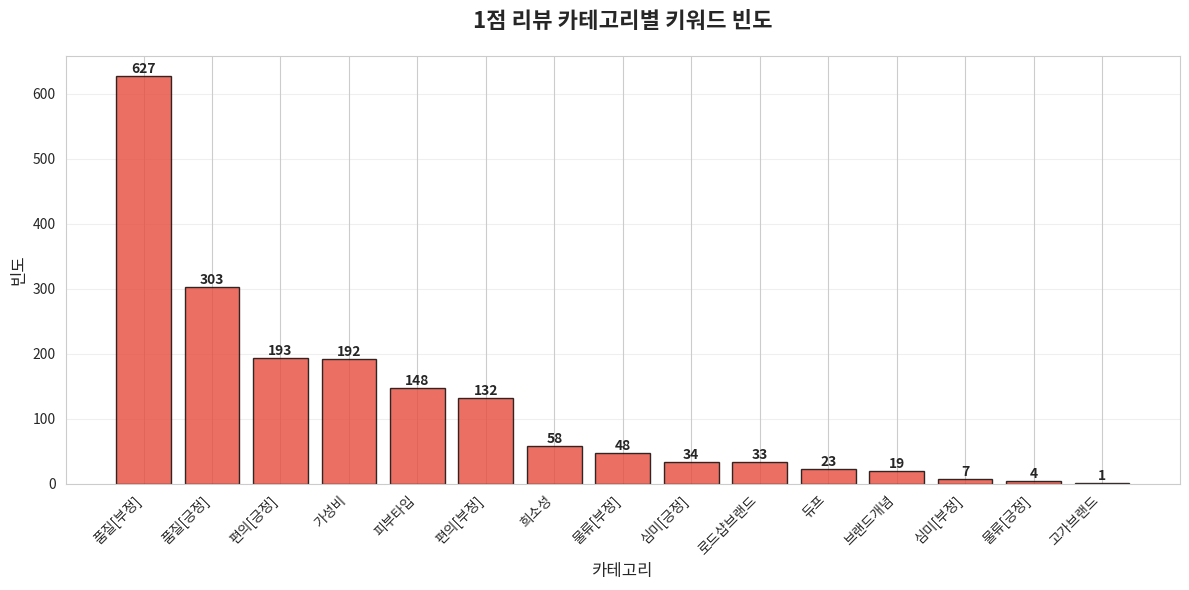

In [52]:
# 시각화
plot_category_comparison(
    low_rating_category_freq.head(15),
    title='1점 리뷰 카테고리별 키워드 빈도',
    color='#E74C3C'
)


=== 1점 리뷰 부정 카테고리 ===
   category  frequency
0    품질[부정]        627
5    편의[부정]        132
7    물류[부정]         48
12   심미[부정]          7

부정 카테고리 비율: 44.7%


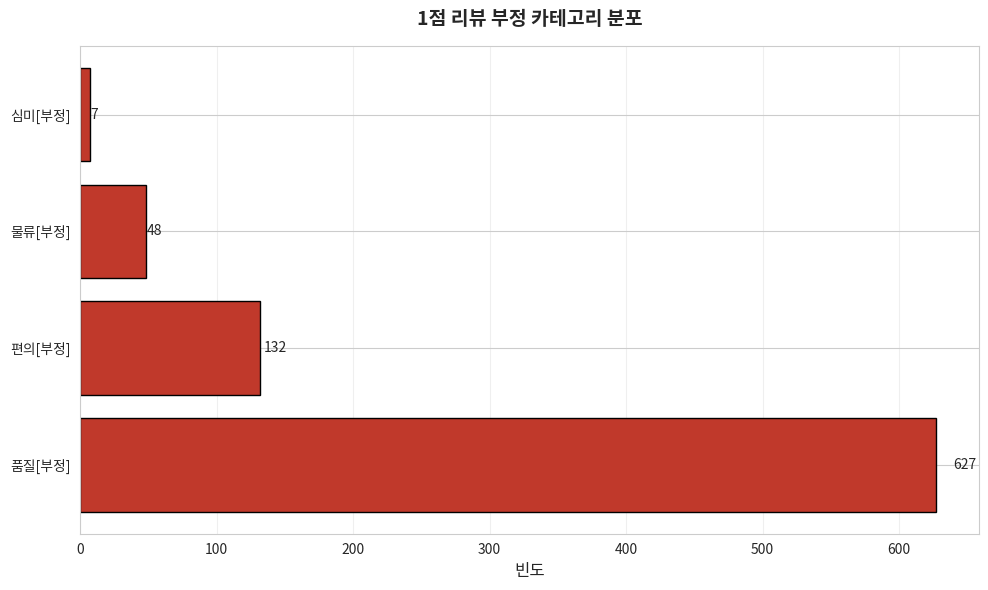

In [53]:
# 부정 카테고리 중점 분석
negative_categories = ['품질[부정]', '편의[부정]', '심미[부정]', '물류[부정]']

negative_freq = low_rating_category_freq[
    low_rating_category_freq['category'].isin(negative_categories)
].sort_values('frequency', ascending=False)

print("\n=== 1점 리뷰 부정 카테고리 ===")
print(negative_freq)

# 부정 카테고리 비율
total_negative = negative_freq['frequency'].sum()
total_all = low_rating_category_freq['frequency'].sum()

print(f"\n부정 카테고리 비율: {total_negative/total_all*100:.1f}%")

# 막대 그래프
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(negative_freq['category'], negative_freq['frequency'], color='#C0392B', edgecolor='black')
ax.set_xlabel('빈도', fontsize=12)
ax.set_title('1점 리뷰 부정 카테고리 분포', fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.3)

for i, (cat, freq) in enumerate(zip(negative_freq['category'], negative_freq['frequency'])):
    ax.text(freq + freq*0.02, i, f'{freq}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

### 12.3. 1점 리뷰 워드클라우드

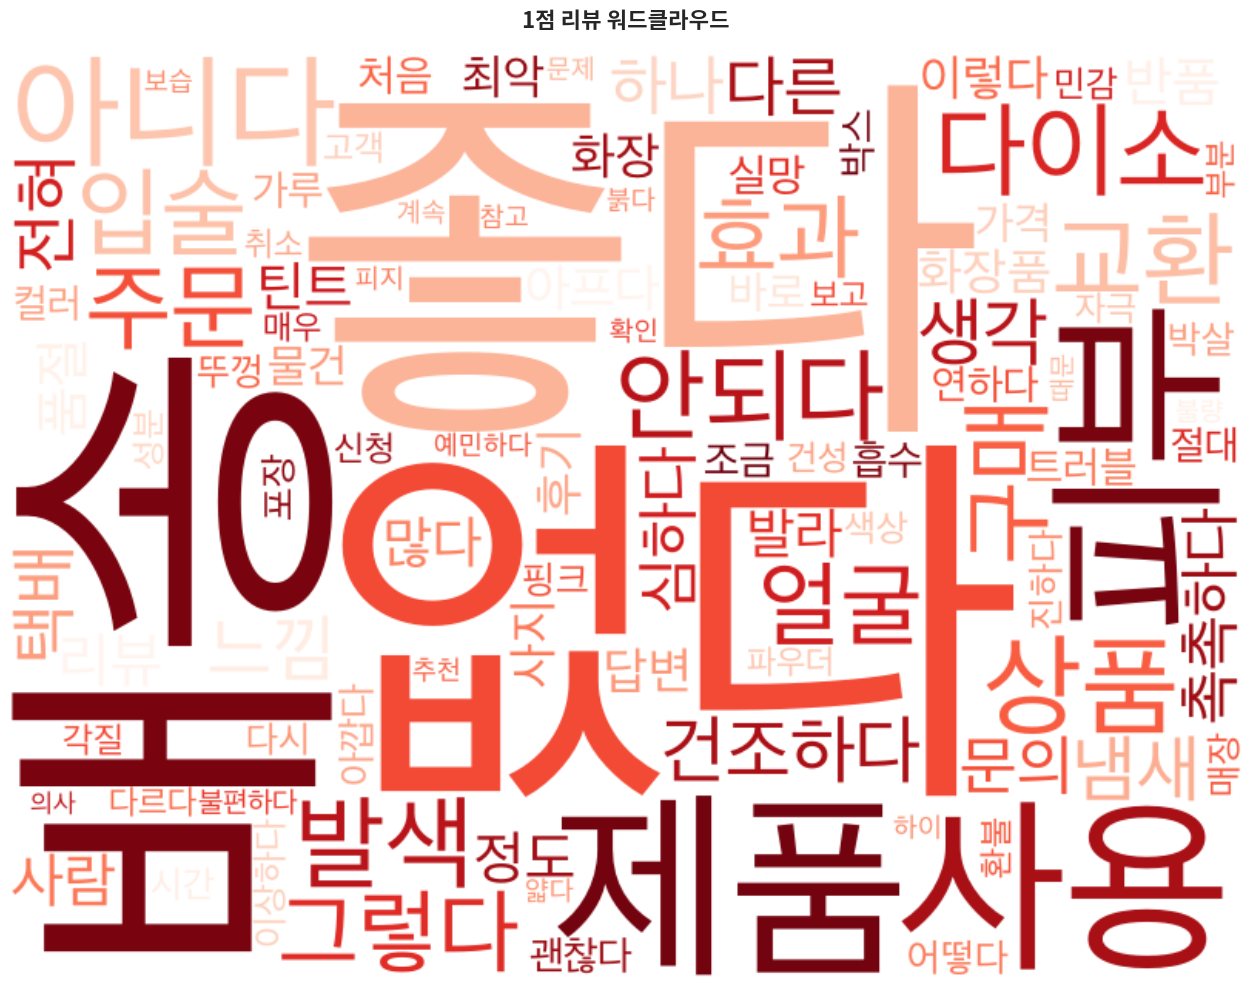

In [54]:
# 1점 리뷰 워드클라우드 생성

create_wordcloud(
    all_low_rating_tokens,
    title='1점 리뷰 워드클라우드',
    figsize=(14, 10),
    max_words=100,
    colormap='Reds',
    background_color='white'
)

5점 리뷰 수: 254,924개
진행중: 1000/1000 (100.0%)
완료: 1000개 리뷰 토큰화
5점 리뷰 토큰 수: 5,394개


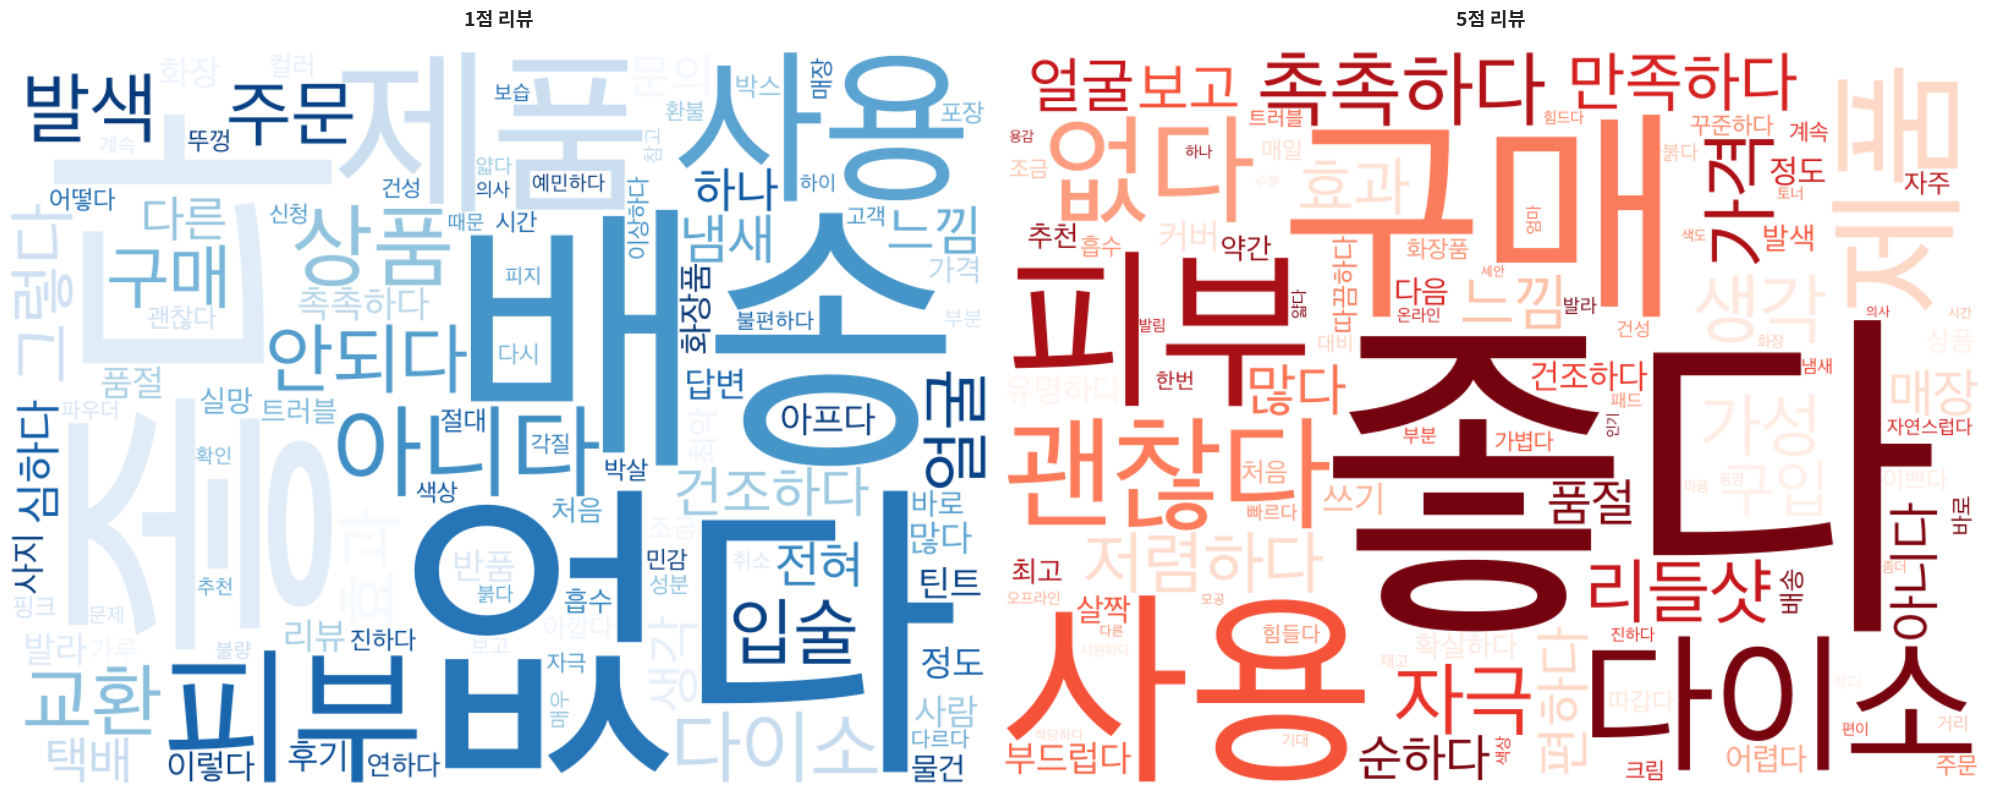

In [55]:
# 1점 vs 5점 리뷰 비교
# 5점 리뷰 추출
high_rating_reviews = reviews_df[reviews_df['rating'] == 5].copy()

print(f"5점 리뷰 수: {len(high_rating_reviews):,}개")

# 5점 리뷰 토큰화
high_rating_texts = high_rating_reviews['text'].fillna('').tolist()
high_rating_tokens_list = tokenize_reviews(
    high_rating_texts[:1000],
    extract_pos=['Noun', 'Adjective'],
    remove_stop=True,
    verbose=True
)

all_high_rating_tokens = []
for tokens in high_rating_tokens_list:
    all_high_rating_tokens.extend(tokens)

print(f"5점 리뷰 토큰 수: {len(all_high_rating_tokens):,}개")

# 비교 워드클라우드
from utils.visualization import create_comparison_wordclouds

create_comparison_wordclouds(
    all_low_rating_tokens,
    all_high_rating_tokens,
    title1='1점 리뷰',
    title2='5점 리뷰',
    figsize=(20, 8)
)

## 모델링: 평점 평균(μ)과 표준편차(σ) 사분면 분석

**분석 목적**:
- 평점의 평균과 표준편차를 축으로 하는 2차원 공간에서 제품을 분류
- 4개 사분면으로 제품군을 구분하여 전략 수립

In [56]:
# 제품별 평점 통계 계산

product_rating_stats = reviews_df.groupby('product_code').agg({
    'rating': ['mean', 'std', 'count']
})

product_rating_stats.columns = ['평균_평점', '평점_표준편차', '리뷰_수']
product_rating_stats = product_rating_stats.reset_index()

# 제품 정보 병합
product_rating_stats = products_df.merge(product_rating_stats, on='product_code', how='left')

# 리뷰 10개 이상인 제품만 분석
product_rating_stats_filtered = product_rating_stats[product_rating_stats['리뷰_수'] >= 10].copy()

print(f"=== 평점 사분면 분석 ===")
print(f"분석 대상 제품: {len(product_rating_stats_filtered)}개 (리뷰 10개 이상)")
print(f"\n평점 통계:")
print(product_rating_stats_filtered[['평균_평점', '평점_표준편차']].describe())

=== 평점 사분면 분석 ===
분석 대상 제품: 846개 (리뷰 10개 이상)

평점 통계:
            평균_평점     평점_표준편차
count  846.000000  846.000000
mean     4.683711    0.678752
std      0.147599    0.187196
min      3.259259    0.000000
25%      4.621739    0.559502
50%      4.710727    0.650567
75%      4.772002    0.777679
max      5.000000    1.801234


In [57]:
# 사분면 기준점 설정

# 평균과 표준편차의 기준점 설정
# 평균 평점은 4.5~4.8에 몰려있으므로 하한선 4.5 적용
median_mean = product_rating_stats_filtered['평균_평점'].median()
median_std = product_rating_stats_filtered['평점_표준편차'].median()

MEAN_THRESHOLD = max(median_mean, 4.5)
STD_THRESHOLD = median_std

print(f"\n사분면 기준점:")
print(f"  평균 평점 중앙값: {median_mean:.2f}점")
print(f"  평균 평점 기준값 (하한선 4.5 적용): {MEAN_THRESHOLD:.2f}점")
print(f"  표준편차 기준값: {STD_THRESHOLD:.2f}")

# 사분면 분류
# Q1: 평균↑ + 표준편차↑ = 바이럴 (오른쪽 위)
# Q2: 평균↓ + 표준편차↑ = 실패 가능성↑ (왼쪽 위)
# Q3: 평균↓ + 표준편차↓ = 무난하지만 존재감 없음 (왼쪽 아래)
# Q4: 평균↑ + 표준편차↓ = 스테디셀러 (오른쪽 아래)
def classify_quadrant(row):
    # 리뷰 수가 30개 미만이면 데이터 부족
    if row['리뷰_수'] < 30:
        return '기타: 데이터 부족'
    
    if row['평균_평점'] >= MEAN_THRESHOLD and row['평점_표준편차'] >= STD_THRESHOLD:
        return 'Q1: 바이럴'
    elif row['평균_평점'] < MEAN_THRESHOLD and row['평점_표준편차'] >= STD_THRESHOLD:
        return 'Q2: 실패 가능성↑'
    elif row['평균_평점'] < MEAN_THRESHOLD and row['평점_표준편차'] < STD_THRESHOLD:
        return 'Q3: 무난하지만 존재감 없음'
    else:  # 평균↑ + 표준편차↓
        return 'Q4: 스테디셀러'

product_rating_stats_filtered['사분면'] = product_rating_stats_filtered.apply(classify_quadrant, axis=1)

# 사분면별 제품 수
quadrant_counts = product_rating_stats_filtered['사분면'].value_counts()
print(f"\n사분면별 제품 수:")
print(quadrant_counts)


사분면 기준점:
  평균 평점 중앙값: 4.71점
  평균 평점 기준값 (하한선 4.5 적용): 4.71점
  표준편차 기준값: 0.65

사분면별 제품 수:
사분면
Q4: 스테디셀러           359
Q2: 실패 가능성↑         355
기타: 데이터 부족           49
Q1: 바이럴              44
Q3: 무난하지만 존재감 없음     39
Name: count, dtype: int64


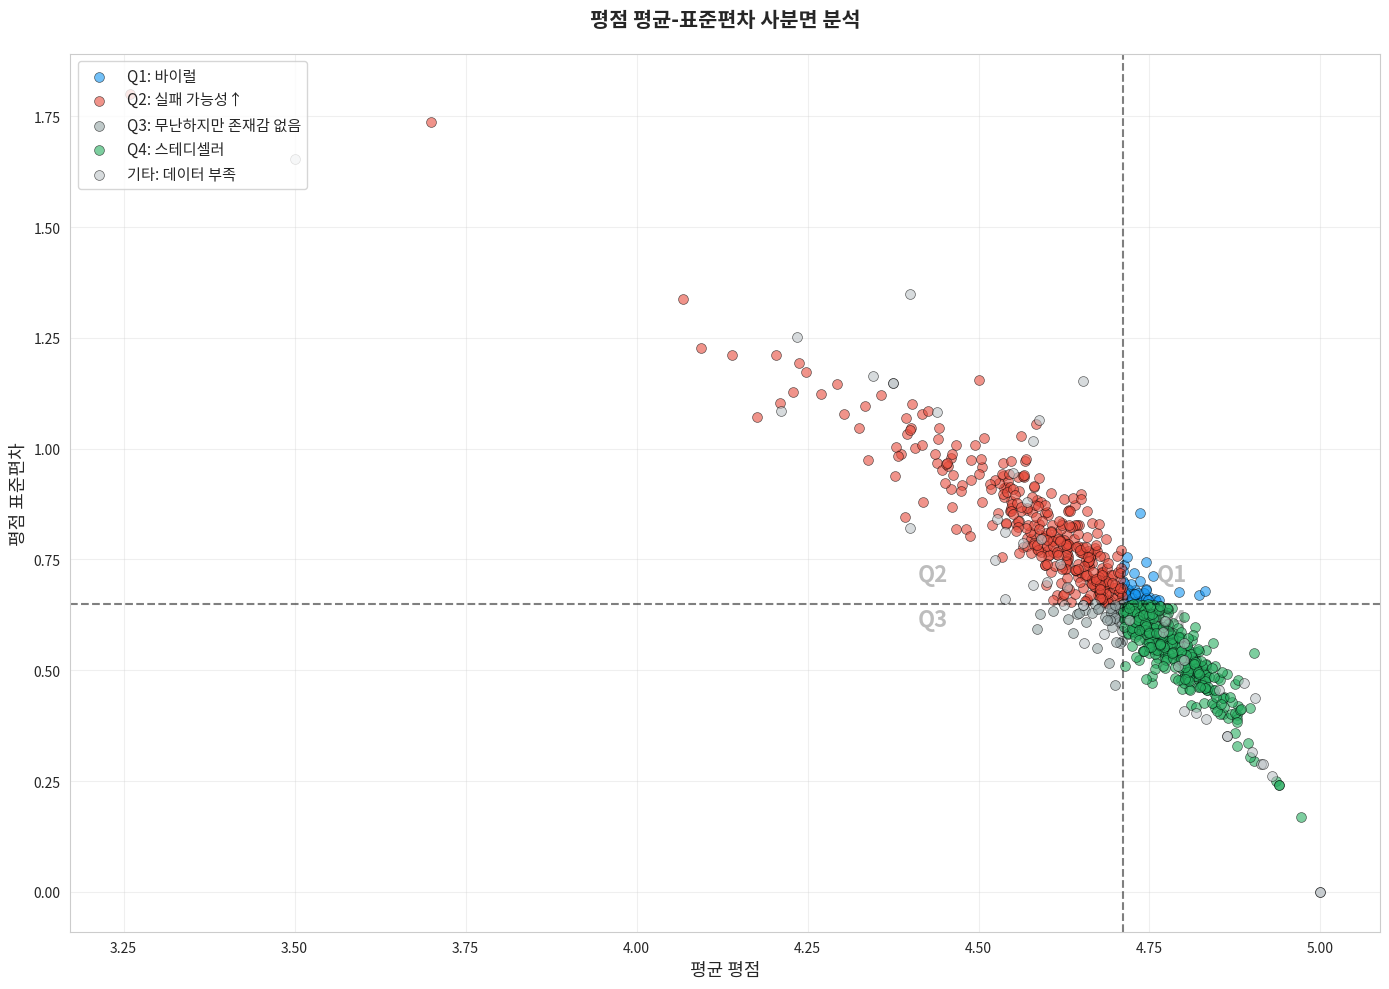

In [58]:
# 사분면 시각화
fig, ax = plt.subplots(figsize=(14, 10))

# 사분면별 색상
colors = {
    'Q1: 바이럴': '#1596F3',        # 오렌지 - 바이럴
    'Q2: 실패 가능성↑': '#E74C3C',      # 빨강 - 실패 가능성↑
    'Q3: 무난하지만 존재감 없음': '#95A5A6',  # 회색 - 무난하지만 존재감 없음
    'Q4: 스테디셀러': '#27AE60',        # 초록 - 스테디셀러
    '기타: 데이터 부족': '#BDC3C7'      # 연회색 - 데이터 부족
}

# 산점도
for quadrant, color in colors.items():
    mask = product_rating_stats_filtered['사분면'] == quadrant
    ax.scatter(
        product_rating_stats_filtered.loc[mask, '평균_평점'],
        product_rating_stats_filtered.loc[mask, '평점_표준편차'],
        c=color, label=quadrant, alpha=0.6, s=50, edgecolors='black', linewidth=0.5
    )

# 기준선
ax.axvline(MEAN_THRESHOLD, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax.axhline(STD_THRESHOLD, color='black', linestyle='--', linewidth=1.5, alpha=0.5)

# 사분면 라벨
# Q1: 평균↑ + 표준편차↑ = 바이럴 (오른쪽 위)
# Q2: 평균↓ + 표준편차↑ = 실패 가능성↑ (왼쪽 위)
# Q3: 평균↓ + 표준편차↓ = 무난하지만 존재감 없음 (왼쪽 아래)
# Q4: 평균↑ + 표준편차↓ = 스테디셀러 (오른쪽 아래)
ax.text(MEAN_THRESHOLD - 0.3, STD_THRESHOLD + 0.05, 'Q2', fontsize=16, fontweight='bold', alpha=0.3)  # 왼쪽 위
ax.text(MEAN_THRESHOLD + 0.05, STD_THRESHOLD + 0.05, 'Q1', fontsize=16, fontweight='bold', alpha=0.3)  # 오른쪽 위
ax.text(MEAN_THRESHOLD + 0.05, STD_THRESHOLD - 0.05, 'Q4', fontsize=16, fontweight='bold', alpha=0.3)  # 오른쪽 아래
ax.text(MEAN_THRESHOLD - 0.3, STD_THRESHOLD - 0.05, 'Q3', fontsize=16, fontweight='bold', alpha=0.3)  # 왼쪽 아래

ax.set_xlabel('평균 평점', fontsize=13)
ax.set_ylabel('평점 표준편차', fontsize=13)
ax.set_title('평점 평균-표준편차 사분면 분석', fontsize=15, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [59]:
# 각 사분면별 제품 샘플 (데이터 부족 제외)

for quadrant in ['Q1: 바이럴', 'Q2: 실패 가능성↑', 'Q3: 무난하지만 존재감 없음', 'Q4: 스테디셀러']:
    print(f"\n{'='*60}")
    print(f"{quadrant}")
    print('='*60)

    # '기타: 데이터 부족' 제외
    product_quadrant_valid = product_rating_stats_filtered[
        product_rating_stats_filtered['사분면'] != '기타: 데이터 부족'
    ].copy()
    
    q_products = product_quadrant_valid[
        product_quadrant_valid['사분면'] == quadrant
    ].sort_values('리뷰_수', ascending=False).head(10)

    print(q_products[['name', '평균_평점', '평점_표준편차', '리뷰_수', 'price', 'brand']])


Q1: 바이럴
                                          name     평균_평점   평점_표준편차    리뷰_수  \
530                셀더마데일리 트랜스포밍 아줄렌카밍 마스크 28 g  4.733245  0.673925  2268.0   
105                         태그 벨벳 세팅 픽서 100 ml  4.712674  0.651067  1152.0   
516                   손앤박 아티 스프레드 컬러 밤(02 피오니)  4.725140  0.664188   895.0   
104                     태그 벨벳 커버 쿠션 15g 누드 라이트  4.718509  0.656963   778.0   
529                 셀더마데일리 트랜스포밍 퍼밍콜라겐 마스크 28g  4.747191  0.658144   534.0   
195  클리덤 저분자 콜라겐 탄력 실타래 크림 기획 세트 40 ml (종근당건강)  4.735354  0.655607   495.0   
168            트윙클팝 퓨어 글래스 틴트(01 미들로즈) by CLIO  4.728665  0.652852   457.0   
304                       입큰 퍼스널 톤 쿠션 블러셔 핑크 슈  4.716590  0.683255   434.0   
346             밀크터치 디어씽 블러리 이펙트 스무드 터치팟 뮤트메모리  4.727700  0.672857   426.0   
331        과일나라 알로에베라 모이스처 아쿠아 수딩 젤 미스트 110 ml  4.724638  0.653930   414.0   

     price     brand  
530   2000    셀더마데일리  
105   5000        태그  
516   3000       손앤박  
104   5000        태그  
529   2000    셀더마

In [60]:
# 사분면별 특징 비교 (데이터 부족 제외)
quadrant_summary = product_quadrant_valid.groupby('사분면').agg({
    'product_code': 'count',
    '평균_평점': 'mean',
    '평점_표준편차': 'mean',
    '리뷰_수': 'mean',
    'price': 'mean'
}).round(2)

quadrant_summary.columns = ['제품_수', '평균_평점', '평점_표준편차', '평균_리뷰수', '평균_가격']

print("\n=== 사분면별 특징 요약 ===")
print(quadrant_summary)


=== 사분면별 특징 요약 ===
                  제품_수  평균_평점  평점_표준편차  평균_리뷰수    평균_가격
사분면                                                    
Q1: 바이럴             44   4.74     0.68  301.84  3409.09
Q2: 실패 가능성↑        355   4.58     0.82  220.03  3683.10
Q3: 무난하지만 존재감 없음    39   4.68     0.61  179.18  3820.51
Q4: 스테디셀러          359   4.78     0.54  598.02  3938.72


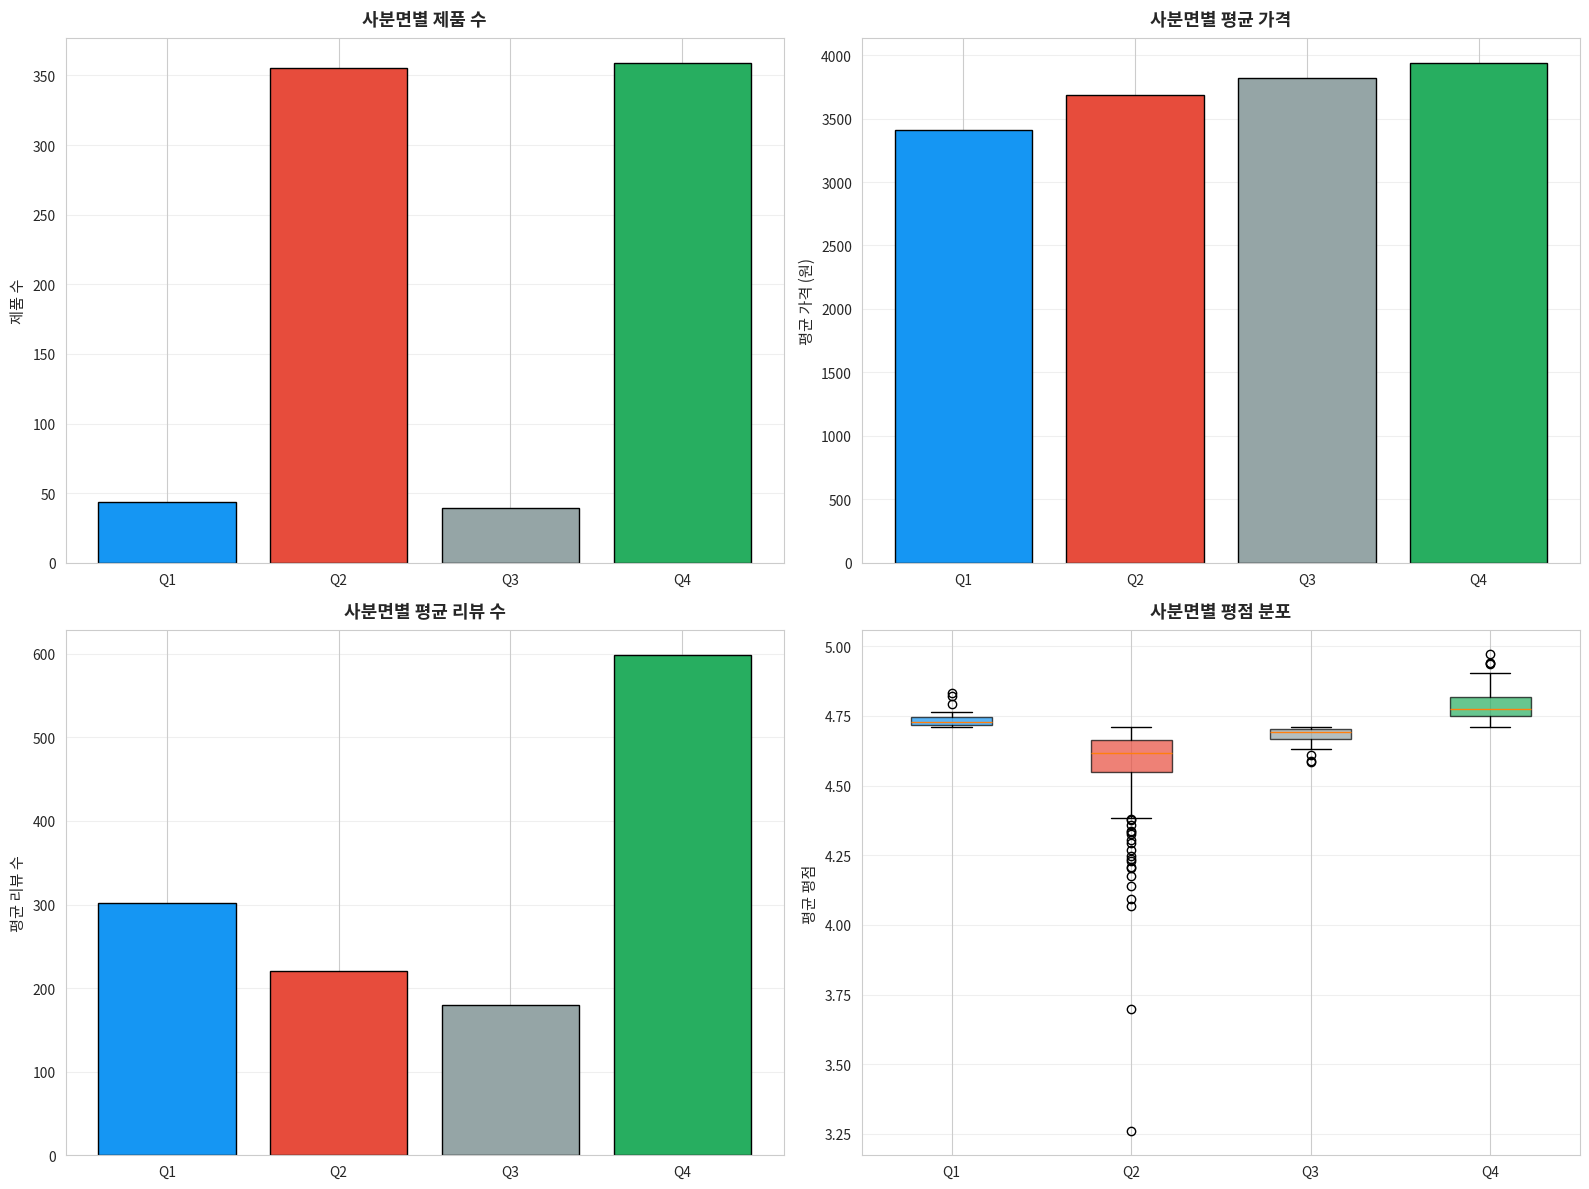

In [61]:
# 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 제품 수
axes[0, 0].bar(range(len(quadrant_summary)), quadrant_summary['제품_수'],
               color=[colors[q] for q in quadrant_summary.index], edgecolor='black')
axes[0, 0].set_xticks(range(len(quadrant_summary)))
axes[0, 0].set_xticklabels([q.split(':')[0] for q in quadrant_summary.index], fontsize=10)
axes[0, 0].set_ylabel('제품 수', fontsize=11)
axes[0, 0].set_title('사분면별 제품 수', fontsize=13, fontweight='bold', pad=10)
axes[0, 0].grid(axis='y', alpha=0.3)

# 평균 가격
axes[0, 1].bar(range(len(quadrant_summary)), quadrant_summary['평균_가격'],
               color=[colors[q] for q in quadrant_summary.index], edgecolor='black')
axes[0, 1].set_xticks(range(len(quadrant_summary)))
axes[0, 1].set_xticklabels([q.split(':')[0] for q in quadrant_summary.index], fontsize=10)
axes[0, 1].set_ylabel('평균 가격 (원)', fontsize=11)
axes[0, 1].set_title('사분면별 평균 가격', fontsize=13, fontweight='bold', pad=10)
axes[0, 1].grid(axis='y', alpha=0.3)

# 평균 리뷰 수
axes[1, 0].bar(range(len(quadrant_summary)), quadrant_summary['평균_리뷰수'],
               color=[colors[q] for q in quadrant_summary.index], edgecolor='black')
axes[1, 0].set_xticks(range(len(quadrant_summary)))
axes[1, 0].set_xticklabels([q.split(':')[0] for q in quadrant_summary.index], fontsize=10)
axes[1, 0].set_ylabel('평균 리뷰 수', fontsize=11)
axes[1, 0].set_title('사분면별 평균 리뷰 수', fontsize=13, fontweight='bold', pad=10)
axes[1, 0].grid(axis='y', alpha=0.3)

# 평점 분포 박스플롯
quadrant_order = ['Q1: 바이럴', 'Q2: 실패 가능성↑', 'Q3: 무난하지만 존재감 없음', 'Q4: 스테디셀러']
rating_data = [product_quadrant_valid[product_quadrant_valid['사분면'] == q]['평균_평점'].values
               for q in quadrant_order]
bp = axes[1, 1].boxplot(rating_data, labels=[q.split(':')[0] for q in quadrant_order],
                         patch_artist=True)
for patch, q in zip(bp['boxes'], quadrant_order):
    patch.set_facecolor(colors[q])
    patch.set_alpha(0.7)
axes[1, 1].set_ylabel('평균 평점', fontsize=11)
axes[1, 1].set_title('사분면별 평점 분포', fontsize=13, fontweight='bold', pad=10)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Step 2: 재구매율로 진짜 스테디셀러 검증

**목적**:
- 별점만으로는 불충분 → 재구매율이 진짜 스테디셀러를 판단하는 핵심 지표
- Q4(스테디셀러) 제품 중 재구매율이 높은 제품 = 진짜 스테디셀러

**검증 방법**:
- Q4 제품 중 재구매율이 높은 제품 추출
- μ↑ + σ↓ + reorder↑ = 진짜 스테디셀러

In [62]:
# Step 2: 재구매율로 진짜 스테디셀러 검증

# 재구매율 계산
product_reorder = reviews_df.groupby('product_code').agg({
    'is_reorder': 'sum',
    'product_code': 'count'
}).rename(columns={'product_code': 'total_reviews', 'is_reorder': 'reorder_count'})
product_reorder['reorder_rate'] = (product_reorder['reorder_count'] / product_reorder['total_reviews'] * 100).round(2)
product_reorder = product_reorder.reset_index()  # product_code를 컬럼으로 변경

# product_rating_stats_filtered와 병합 (product_code 기준)
product_with_reorder = product_rating_stats_filtered.merge(
    product_reorder[['product_code', 'reorder_count', 'total_reviews', 'reorder_rate']], 
    on='product_code', 
    how='left'
)

# Q4 (스테디셀러) 제품 중 재구매율 상위 추출
q4_products = product_with_reorder[product_with_reorder['사분면'] == 'Q4: 스테디셀러'].copy()
q4_products_sorted = q4_products.sort_values('reorder_rate', ascending=False)

print("=== Q4(스테디셀러) 제품 중 재구매율 상위 20개 ===")
print(q4_products_sorted[['name', '평균_평점', '평점_표준편차', '리뷰_수', 'reorder_rate']].head(20))

# 진짜 스테디셀러 정의: Q4 + 재구매율 30% 이상
true_steady = q4_products[q4_products['reorder_rate'] >= 30]
print(f"\n✓ 진짜 스테디셀러 제품: {len(true_steady)}개 (Q4 중 {len(true_steady)/len(q4_products)*100:.1f}%)")

=== Q4(스테디셀러) 제품 중 재구매율 상위 20개 ===
                                      name     평균_평점   평점_표준편차    리뷰_수  \
799      VT 리들샷 300 페이셜 부스팅 퍼스트 앰플 2ml*6개입  4.903232  0.295999  9869.0   
800      VT 리들샷 100 페이셜 부스팅 퍼스트 앰플 2ml*6개입  4.896994  0.304317  9815.0   
745                     6중날 오픈 카트리지 면도기 1P  4.837209  0.484534    43.0   
138                 본셉 비타씨 동결 건조 더블샷 앰플 키트  4.788491  0.553383  5839.0   
798      VT 리들샷 500 페이셜 부스팅 퍼스트 앰플 2ml*8개입  4.820836  0.547343  3254.0   
796         VT 리들샷 페이셜 리페어 EGF 에센스 2ml*6개입  4.796354  0.542542  1591.0   
789  VT 콜라겐 리들샷 S50 페이셜 부스팅 퍼스트 앰플 2ml*6개입  4.820341  0.496102  3284.0   
792                     VT 시카 카밍 에센스 30 ml  4.826087  0.466252   437.0   
797      VT 리들샷 페이셜 레디언스 글루타치온 에센스 2ml*6개입  4.823850  0.462880  1652.0   
793                 VT 시카 슬리핑 마스크 4 ml 6개입  4.836007  0.462398  3366.0   
262               제이엠솔루션 아크클리어 클렌징폼 150 ml  4.857143  0.401297    56.0   
145           본셉 레티놀 2500 IU 링클샷 퍼펙터 15 ml  4.773573  0.561073  4571.0   
731

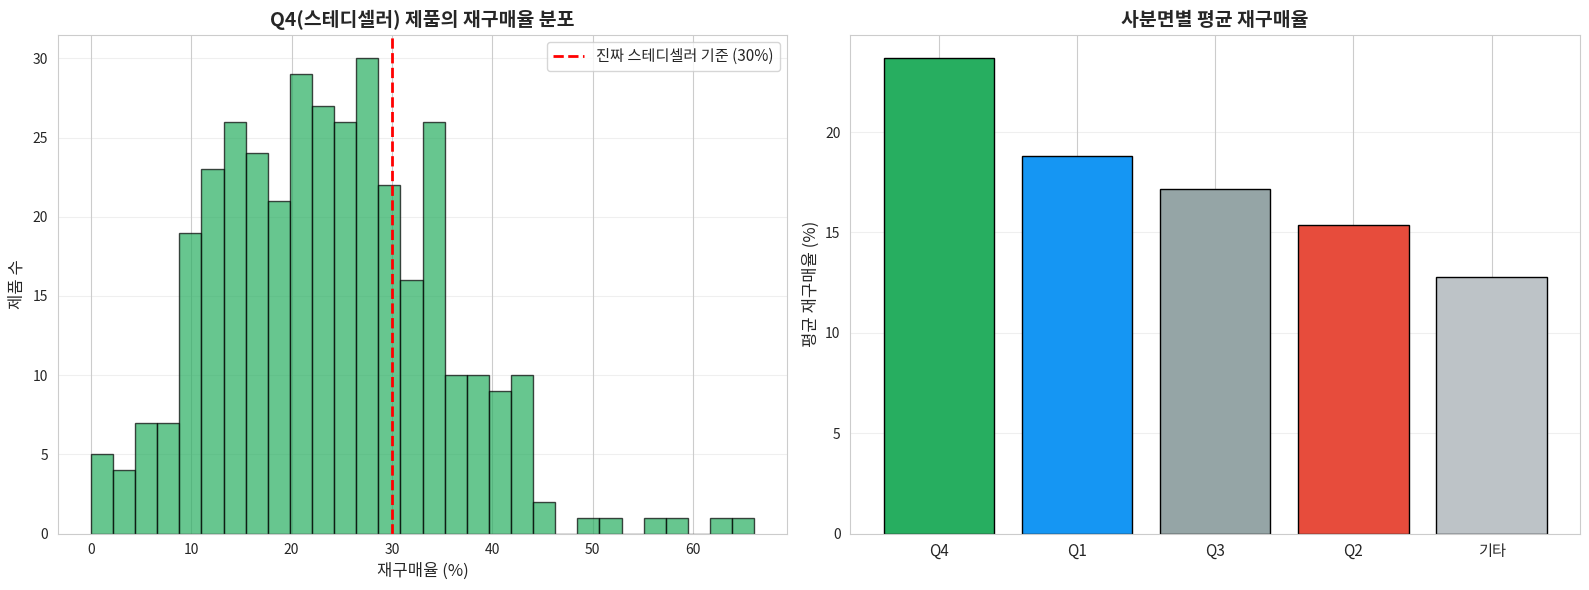

In [63]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Q4 재구매율 분포
axes[0].hist(q4_products['reorder_rate'].dropna(), bins=30, color='#27AE60', alpha=0.7, edgecolor='black')
axes[0].axvline(30, color='red', linestyle='--', linewidth=2, label='진짜 스테디셀러 기준 (30%)')
axes[0].set_xlabel('재구매율 (%)', fontsize=12)
axes[0].set_ylabel('제품 수', fontsize=12)
axes[0].set_title('Q4(스테디셀러) 제품의 재구매율 분포', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# 사분면별 평균 재구매율
quad_reorder = product_with_reorder.groupby('사분면')['reorder_rate'].mean().sort_values(ascending=False)
quad_colors = [colors[q] for q in quad_reorder.index]
axes[1].bar(range(len(quad_reorder)), quad_reorder.values, color=quad_colors, edgecolor='black')
axes[1].set_xticks(range(len(quad_reorder)))
axes[1].set_xticklabels([q.split(':')[0] for q in quad_reorder.index], fontsize=11)
axes[1].set_ylabel('평균 재구매율 (%)', fontsize=12)
axes[1].set_title('사분면별 평균 재구매율', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Step 3: Engagement 대비 재구매 비교로 바이럴 제품 탐지

**목적**:
- engagement↑ + reorder↓ = 바이럴 (화제성은 높으나 재구매는 낮음)
- Q1(바이럴) 제품 중 engagement가 높고 재구매율이 낮은 제품 = 진짜 바이럴

**검증 방법**:
- engagement_score 상위 + 재구매율 하위 제품 추출
- 이런 제품은 "한번 써보기"로 인기는 있지만 재구매로 이어지지 않음

In [64]:
# Step 3.1: Engagement 대비 재구매 비교로 바이럴 탐지(Q1)

# engagement_score는 이미 product_with_reorder에 포함되어 있음 (products_df 병합 결과)
# 만약 없다면 추가 병합
if 'engagement_score' not in product_with_reorder.columns:
    product_with_reorder = product_with_reorder.merge(
        products_df[['product_code', 'engagement_score']], 
        on='product_code', 
        how='left'
    )

# Q1 (바이럴) 제품 중 engagement 높고 재구매율 낮은 제품
q1_products = product_with_reorder[product_with_reorder['사분면'] == 'Q1: 바이럴'].copy()

# engagement 상위 30%, 재구매율 하위 30%
eng_threshold = q1_products['engagement_score'].quantile(0.70)
reorder_threshold = q1_products['reorder_rate'].quantile(0.30)

true_hit = q1_products[
    (q1_products['engagement_score'] >= eng_threshold) & 
    (q1_products['reorder_rate'] <= reorder_threshold)
]

print("=== 진짜 바이럴 제품 (engagement↑ + reorder↓) ===")
print(f"총 {len(true_hit)}개 제품")
print("\n상위 15개:")
print(true_hit.sort_values('engagement_score', ascending=False)[
    ['name', '평균_평점', 'engagement_score', 'reorder_rate', 'likes', 'shares']
].head(15))

=== 진짜 바이럴 제품 (engagement↑ + reorder↓) ===
총 3개 제품

상위 15개:
                                     name     평균_평점  engagement_score  \
346        밀크터치 디어씽 블러리 이펙트 스무드 터치팟 뮤트메모리  4.727700           1532.55   
304                  입큰 퍼스널 톤 쿠션 블러셔 핑크 슈  4.716590            839.90   
182  트윙클팝 레이어링 무드 팔레트(03 카라멜글레이즈) by CLIO  4.728155            675.00   

     reorder_rate  likes  shares  
346         10.33   8581      37  
304         13.36   3870      69  
182         11.33   3319      24  


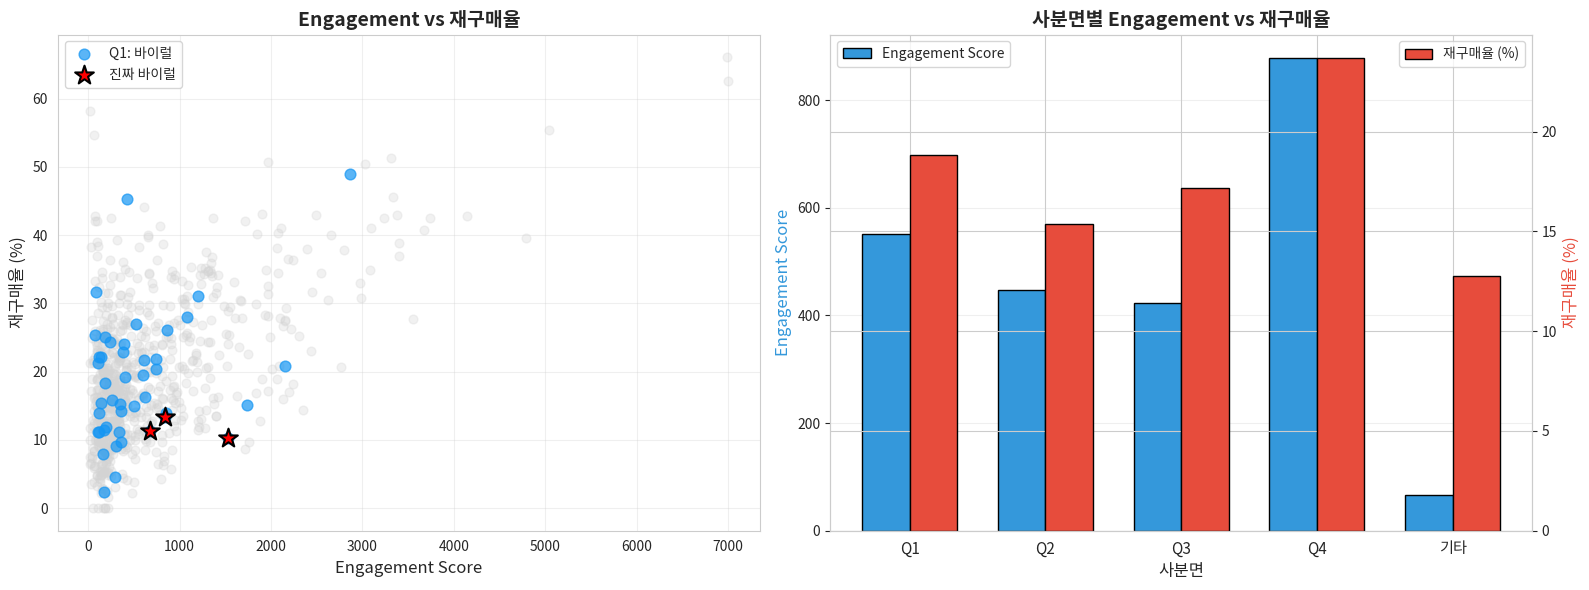

In [65]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for quadrant in ['Q2: 실패 가능성↑', 'Q3: 무난하지만 존재감 없음', 'Q4: 스테디셀러']:
    mask = product_with_reorder['사분면'] == quadrant
    axes[0].scatter(
        product_with_reorder.loc[mask, 'engagement_score'],
        product_with_reorder.loc[mask, 'reorder_rate'],
        c='lightgray', alpha=0.3, s=40
    )

# 강조: Q1
for quadrant in ['Q1: 바이럴']:
    mask = product_with_reorder['사분면'] == quadrant
    axes[0].scatter(
        product_with_reorder.loc[mask, 'engagement_score'],
        product_with_reorder.loc[mask, 'reorder_rate'],
        c=colors[quadrant], label=quadrant, alpha=0.7, s=60
    )

# 진짜 바이럴 강조
axes[0].scatter(
    true_hit['engagement_score'], true_hit['reorder_rate'],
    c='red', s=200, marker='*', edgecolors='black', linewidth=1.5,
    label='진짜 바이럴', zorder=5
)

axes[0].set_xlabel('Engagement Score', fontsize=12)
axes[0].set_ylabel('재구매율 (%)', fontsize=12)
axes[0].set_title('Engagement vs 재구매율', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# 사분면별 engagement vs 재구매율 평균
quad_metrics = product_with_reorder.groupby('사분면').agg({
    'engagement_score': 'mean',
    'reorder_rate': 'mean'
}).round(2)

x = np.arange(len(quad_metrics))
width = 0.35

bars1 = axes[1].bar(x - width/2, quad_metrics['engagement_score'], width, 
                    label='Engagement Score', color='#3498DB', edgecolor='black')
ax2 = axes[1].twinx()
bars2 = ax2.bar(x + width/2, quad_metrics['reorder_rate'], width,
                label='재구매율 (%)', color='#E74C3C', edgecolor='black')

axes[1].set_xlabel('사분면', fontsize=12)
axes[1].set_ylabel('Engagement Score', fontsize=12, color='#3498DB')
ax2.set_ylabel('재구매율 (%)', fontsize=12, color='#E74C3C')
axes[1].set_title('사분면별 Engagement vs 재구매율', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels([q.split(':')[0] for q in quad_metrics.index], fontsize=11)
axes[1].legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [66]:
# Step 3.2: Engagement 대비 재구매 비교로 바이럴 탐지 (Q2)
# engagement_score는 이미 product_with_reorder에 포함되어 있음 (products_df 병합 결과)
# 만약 없다면 추가 병합
if 'engagement_score' not in product_with_reorder.columns:
    product_with_reorder = product_with_reorder.merge(
        products_df[['product_code', 'engagement_score']], 
        on='product_code', 
        how='left'
    )

# Q2: 실패 가능성↑ 제품 중 engagement 높고 재구매율 낮은 제품
q1_products = product_with_reorder[product_with_reorder['사분면'] == 'Q2: 실패 가능성↑'].copy()

# engagement 상위 30%, 재구매율 하위 30%
eng_threshold = q1_products['engagement_score'].quantile(0.70)
reorder_threshold = q1_products['reorder_rate'].quantile(0.30)

true_hit = q1_products[
    (q1_products['engagement_score'] >= eng_threshold) & 
    (q1_products['reorder_rate'] <= reorder_threshold)
]

print("=== 바이럴 제품? (engagement↑ + reorder↓) ===")
print(f"총 {len(true_hit)}개 제품")
print("\n상위 15개:")
print(true_hit.sort_values('engagement_score', ascending=False)[
    ['name', '평균_평점', 'engagement_score', 'reorder_rate', 'likes', 'shares']
].head(15))

=== 바이럴 제품? (engagement↑ + reorder↓) ===
총 22개 제품

상위 15개:
                                        name     평균_평점  engagement_score  \
35           [72 리틀 오스틴]프릴루드 딘토 노스탈지아 아이 팔레트  4.665934           1753.85   
34           [73 리틀 살로메]프릴루드 딘토 노스탈지아 아이 팔레트  4.647321            918.05   
272                         줌 바이 정샘물 글로시업 쿠션  4.524590            908.45   
665             더랩바이블랑두 클리어히알결광 세럼미스트 150 ml  4.651899            824.90   
277  [21호 엔라이트]줌 바이 정샘물 듀이핏 스파츌라 파운데이션 25 ml  4.598425            812.35   
183       트윙클팝 레이어링 무드 팔레트(02 피치블렌딩) by CLIO  4.607903            809.90   
298                입큰 퍼스널 퍼퓸 파우더 블러셔 뮤티드 베이지  4.643098            806.40   
53             [12 헤이지 로즈]프릴루드 딘토 라벨르로즈 립라이너  4.680723            797.50   
276  [21호 엔라이트]줌 바이 정샘물 새틴핏 스파츌라 파운데이션 25 ml  4.685714            764.75   
345          밀크터치 디어씽 블러리 이펙트 스무드 터치팟 소프트베이비  4.606299            740.60   
114                         태그 듀이멜팅밤(2호_로즈티)  4.670683            676.80   
224        코코가가 바이 포렌코즈 냥 젤리 

In [67]:
# Step 3.3: Engagement 대비 재구매 비교로 바이럴 탐지 (Q1 + Q2 동시)

# engagement_score는 이미 product_with_reorder에 포함되어 있음 (products_df 병합 결과)
# 만약 없다면 추가 병합
if 'engagement_score' not in product_with_reorder.columns:
    product_with_reorder = product_with_reorder.merge(
        products_df[['product_code', 'engagement_score']], 
        on='product_code', 
        how='left'
    )

# Q1: 바이럴 + Q2: 실패 가능성↑ 제품 동시 선택
q12_products = product_with_reorder[
    product_with_reorder['사분면'].isin(['Q1: 바이럴', 'Q2: 실패 가능성↑'])
].copy()

# engagement 상위 30%, 재구매율 하위 30%
eng_threshold = q12_products['engagement_score'].quantile(0.7)
reorder_threshold = q12_products['reorder_rate'].quantile(0.3)

true_hit = q12_products[
    (q12_products['engagement_score'] >= eng_threshold) & 
    (q12_products['reorder_rate'] <= reorder_threshold)
]

print("=== 바이럴 제품 (Q1 + Q2 / engagement↑ + reorder↓) ===")
print(f"총 {len(true_hit)}개 제품")
print("\n상위 15개:")

print(
    true_hit.sort_values('engagement_score', ascending=False)[
        ['사분면', 'name', '평균_평점', 'engagement_score', 'reorder_rate', 'likes', 'shares']
    ].head(15)
)

=== 바이럴 제품 (Q1 + Q2 / engagement↑ + reorder↓) ===
총 21개 제품

상위 15개:
             사분면                                     name     평균_평점  \
35   Q2: 실패 가능성↑          [72 리틀 오스틴]프릴루드 딘토 노스탈지아 아이 팔레트  4.665934   
346      Q1: 바이럴           밀크터치 디어씽 블러리 이펙트 스무드 터치팟 뮤트메모리  4.727700   
34   Q2: 실패 가능성↑          [73 리틀 살로메]프릴루드 딘토 노스탈지아 아이 팔레트  4.647321   
272  Q2: 실패 가능성↑                         줌 바이 정샘물 글로시업 쿠션  4.524590   
665  Q2: 실패 가능성↑             더랩바이블랑두 클리어히알결광 세럼미스트 150 ml  4.651899   
277  Q2: 실패 가능성↑  [21호 엔라이트]줌 바이 정샘물 듀이핏 스파츌라 파운데이션 25 ml  4.598425   
183  Q2: 실패 가능성↑       트윙클팝 레이어링 무드 팔레트(02 피치블렌딩) by CLIO  4.607903   
298  Q2: 실패 가능성↑                입큰 퍼스널 퍼퓸 파우더 블러셔 뮤티드 베이지  4.643098   
53   Q2: 실패 가능성↑            [12 헤이지 로즈]프릴루드 딘토 라벨르로즈 립라이너  4.680723   
276  Q2: 실패 가능성↑  [21호 엔라이트]줌 바이 정샘물 새틴핏 스파츌라 파운데이션 25 ml  4.685714   
345  Q2: 실패 가능성↑          밀크터치 디어씽 블러리 이펙트 스무드 터치팟 소프트베이비  4.606299   
114  Q2: 실패 가능성↑                         태그 듀이멜팅밤(2호_로즈티)  4.670683   
224  Q2: 

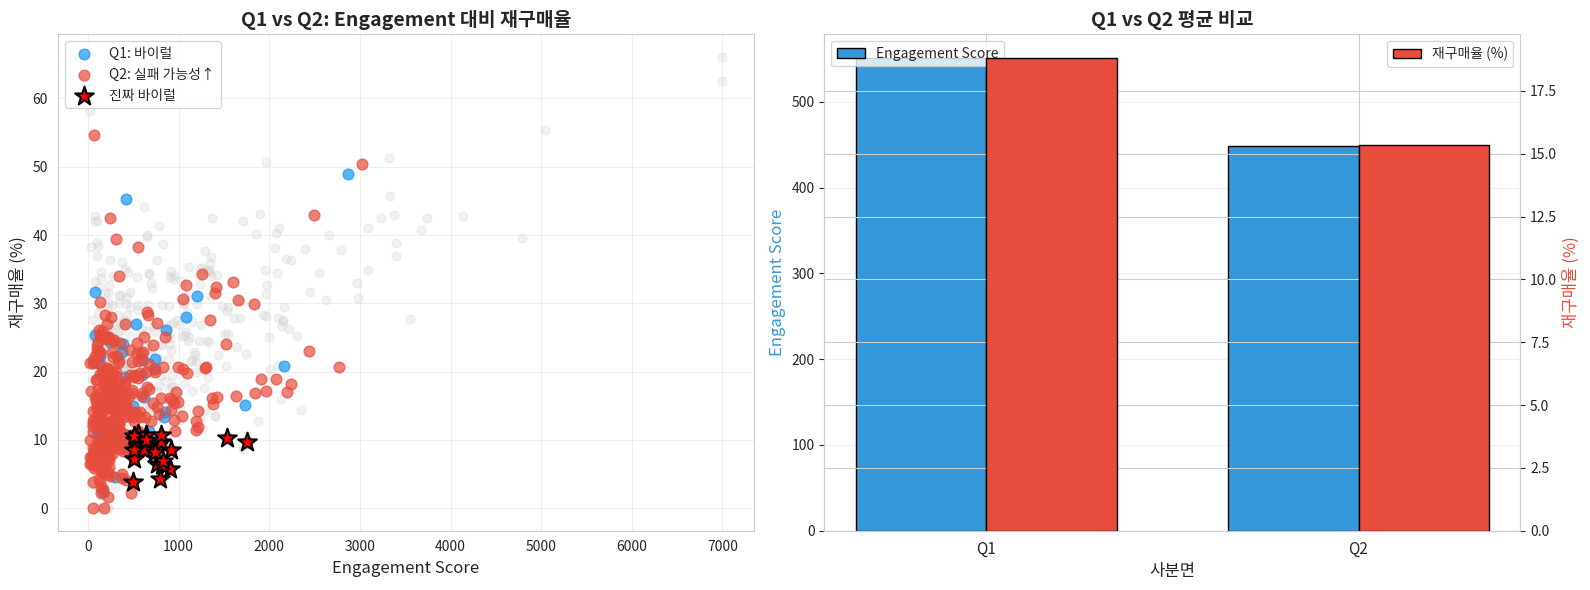

In [68]:
# 시각화: Q1 + Q2 
fig, axes = plt.subplots(1, 2, figsize=(16, 6))


for quadrant in ['Q3: 무난하지만 존재감 없음', 'Q4: 스테디셀러']:
    mask = product_with_reorder['사분면'] == quadrant
    axes[0].scatter(
        product_with_reorder.loc[mask, 'engagement_score'],
        product_with_reorder.loc[mask, 'reorder_rate'],
        c='lightgray', alpha=0.3, s=40
    )

# 강조: Q1, Q2
for quadrant in ['Q1: 바이럴', 'Q2: 실패 가능성↑']:
    mask = product_with_reorder['사분면'] == quadrant
    axes[0].scatter(
        product_with_reorder.loc[mask, 'engagement_score'],
        product_with_reorder.loc[mask, 'reorder_rate'],
        c=colors[quadrant], label=quadrant, alpha=0.7, s=60
    )

# 진짜 바이럴 강조
axes[0].scatter(
    true_hit['engagement_score'],
    true_hit['reorder_rate'],
    c='red', s=200, marker='*', edgecolors='black',
    linewidth=1.5, label='진짜 바이럴', zorder=5
)

axes[0].set_xlabel('Engagement Score', fontsize=12)
axes[0].set_ylabel('재구매율 (%)', fontsize=12)
axes[0].set_title('Q1 vs Q2: Engagement 대비 재구매율', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

quad_metrics = (
    product_with_reorder[
        product_with_reorder['사분면'].isin(['Q1: 바이럴', 'Q2: 실패 가능성↑'])
    ]
    .groupby('사분면')
    .agg({
        'engagement_score': 'mean',
        'reorder_rate': 'mean'
    })
    .round(2)
)

x = np.arange(len(quad_metrics))
width = 0.35

bars1 = axes[1].bar(
    x - width/2, quad_metrics['engagement_score'], width,
    label='Engagement Score', color='#3498DB', edgecolor='black'
)

ax2 = axes[1].twinx()
bars2 = ax2.bar(
    x + width/2, quad_metrics['reorder_rate'], width,
    label='재구매율 (%)', color='#E74C3C', edgecolor='black'
)

axes[1].set_xlabel('사분면', fontsize=12)
axes[1].set_ylabel('Engagement Score', fontsize=12, color='#3498DB')
ax2.set_ylabel('재구매율 (%)', fontsize=12, color='#E74C3C')

axes[1].set_title('Q1 vs Q2 평균 비교', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels([q.split(':')[0] for q in quad_metrics.index], fontsize=11)

axes[1].legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 종합 인사이트

**핵심 발견**:

1. **별점만으로는 부족**
   - 평균 평점(μ)과 표준편차(σ)는 1차 필터링 역할
   - 평균 평점 하한선 4.5 적용 (분포가 4.5~4.8에 집중)
   - 진짜 성공 제품은 재구매율과 engagement로 검증

2. **스테디셀러의 조건 (Q4)**
   - μ가 높고 σ가 낮음 (평균↑ + 표준편차↓)
   - 재구매율 20% 이상
   - → 안정적이고 꾸준히 팔리는 제품

3. **바이럴의 조건 (Q1)**
   - μ가 높고 σ가 높음 (평균↑ + 표준편차↑)
   - Engagement Score가 높음 (likes, shares 많음)
   - 재구매율은 상대적으로 낮음
   - → 화제성은 있지만 일회성 구매, 호불호 갈림

4. **실패 가능성↑ 제품 (Q2)**
   - μ가 낮고 σ가 높음 (평균↓ + 표준편차↑)
   - 1점 리뷰 비율 높음
   - → 품질 개선 필요, 실패 가능성 높음

5. **무난하지만 존재감 없음 (Q3)**
   - μ가 낮고 σ도 낮음 (평균↓ + 표준편차↓)
   - → 무난하지만 특별한 장점 없음, 관심도 낮음